# 第二次讀書會_Group3
- 我們抓取ETtoday新聞雲中的「政治」、「社會」、「體育」、「財經」、「影視」等五大板的新聞。
- 所有板塊皆爬取約2500篇文章的網址、標題、分類、內文。
- 並將第二次讀書會內容分成**三大部分**，資料集也有所差異；三大部分分別為 :

1. **Week 6** : POS,NER等第二次情緒分析的內容/使用政治版、社會版新聞
2. **Week 8** : TF-IDF,N-gram分詞與字詞共現圖/使用財經版新聞
3. **Week 10** : 文件分類模型/使用財經、社會、體育版新聞



In [3]:
# 授權讀取雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

# 移至當前工作目錄
%cd /content/drive/Shareddrives/社媒讀書會/第二次讀書會

Mounted at /content/drive
/content/drive/Shareddrives/社媒讀書會/第二次讀書會


# 第一部分
## 分析目標
分析主題：2021-10-01 ~ 2021-12-03　期間，ETtoday新聞網站內的五大類別:「政治」、「社會」之新聞文章分析
#### 藉由本次的分析，希望可以回答以下問題：

1. 近期各大版報導的熱門人物、組織有哪些，新聞的主要討論話題(主題)為何？
  * NER抓出特定實體，POS詞性辨識找出關鍵字分析
  * 查看相關推文、關鍵字
2. 近期各大版的新聞情緒分布的趨勢如何，正面和負面的新聞主要的討論焦點?
  * SnowNLP 情緒分析推測文章中句子的正負情緒
  * 文字雲、關鍵字找出相關討論事件

大綱
1. 套件安裝
2. CKIP安裝
3. 新聞文章抓取&CKIP標註
  * 使用爬蟲抓取文章
  * 將新聞用coreNLP進行處理
  * NER分析
  * POS分析
  * SnowNLP情緒分析
4. 結論

## 1. 套件安裝

In [ ]:
# 安裝會使用到的套件
%pip install ckiptagger[tf,gdown] wordcloud tweepy==3.10.0 SnowNLP

In [ ]:
%cd /content/drive/Shareddrives/社媒讀書會/第二次讀書會

In [ ]:
# 確認當前工作目錄
%pwd

'/content'

In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator
import tweepy as tw

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

## 2. CKIP 安裝

In [ ]:
data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

Permission denied: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
Maybe you need to change permission over 'Anyone with the link'?


In [ ]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/usr/local/lib/python3.7/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:988: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  partitioner=maybe_partitioner)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:996: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=initializer)
/usr/local/lib/python3.7/dist-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class

## 3. 新聞文章抓取 & CKIP 標註

### 3.1 使用爬蟲抓取五個類別的新聞文章

首先為政治類

In [ ]:
# 讀取已經抓取完成的新聞文章
news_df = pd.read_csv("./raw_data/MetaData_politics.csv")
news_df.head(3)

,id,artDate,title,category,url,content
0,0.0,2021/12/2 23:26,高嘉瑜被打還去林母告別式 馬文鈺批林秉樞：有點像邪教,政治,https://www.ettoday.net/news/20211202/2137476.htm,記者黃巈禾／台北報導外界質疑民進黨立委高嘉瑜為何被男友林秉樞家暴後，沒在第一時間報警，還在1...
1,1.0,2021/12/2 23:26,高嘉瑜遭網軍威脅證據！20天前湧「詭異斗內」：不堪事想被公開？,政治,https://www.ettoday.net/news/20211202/2137472.htm,▲黃揚明揭露，有網友發現高嘉瑜在進行節目直播時，出現3則疑似網軍的詭異斗內。（圖／翻攝自Fa...
2,2.0,2021/12/2 22:54,馬文鈺爆林秉樞找金融鉅子、政界施壓報導 威脅高嘉瑜逆向操作,政治,https://www.ettoday.net/news/20211202/2137452.htm,記者黃巈禾／台北報導民進黨立委高嘉瑜遭男友林秉樞施暴。她的前男友馬文鈺今（2日）爆料，林秉樞...


### 3.2 將新聞文章用coreNLP進行處理
將新聞資料使用coreNLP進行自然語言處理

In [ ]:
news_df['content'].head()

0    記者黃巈禾／台北報導外界質疑民進黨立委高嘉瑜為何被男友林秉樞家暴後，沒在第一時間報警，還在1...
1    ▲黃揚明揭露，有網友發現高嘉瑜在進行節目直播時，出現3則疑似網軍的詭異斗內。（圖／翻攝自Fa...
2    記者黃巈禾／台北報導民進黨立委高嘉瑜遭男友林秉樞施暴。她的前男友馬文鈺今（2日）爆料，林秉樞...
3    ▲中選會舉辦反萊豬公投第四場意見發表會，正方代表蘇偉碩、反方代表姜至剛。（圖／中選會提供） ...
4    ▲行政院長蘇貞昌。（資料照／記者李毓康攝）記者呂晏慈／台北報導立法院3日將邀請行政院長蘇貞昌...
Name: content, dtype: object

(1) 定義文字清理的相關function

In [ ]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除括號()+括號內的字詞 // 內容大多是圖片描述等不重要的資訊
    2. 去除 記者XXX/ 這段詞   // 去掉報導新聞的記者名字
    3. 去除特殊符號字元
    4. 保留數字
    5. 依照斷句字元進行斷句，全形的分號、逗號、句號、問號以及驚嘆號
    6. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─▲⋯]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#    paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), str(article).split("\n")))

#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'\（[^（）]*\）','', clean_paragraph) #去除全形括號()+括號內的字詞: 內容大多是圖片描述等不重要的資訊
            clean_paragraph = re.sub(r'記者.+／.*報導','', clean_paragraph) #去除 記者XXX/OO報導 這句話: 去掉報導新聞的記者名字
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #去除空格
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph) #去除特殊字元
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

(2) CKIP 設定
+ 讀入自定義的政治名詞辭典

In [ ]:
# 自定義辭典
with open('./dict/politics_dict.txt',encoding="utf-8") as f:
    lines = f.read().splitlines()

dict_finance = {k: 1 for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict_finance)
print(dictionary2)

[(2, {'工黨': 1.0, '新黨': 1.0, '立委': 1.0, '議會': 1.0, '總統': 1.0, '政府': 1.0, '政治': 1.0, '制度': 1.0, '法規': 1.0, '政策': 1.0, '公投': 1.0, '投票': 1.0, '藍營': 1.0, '綠營': 1.0}), (3, {'民進黨': 1.0, '國民黨': 1.0, '民眾黨': 1.0, '公民黨': 1.0, '親民黨': 1.0, '無黨籍': 1.0, '立法院': 1.0, '黨主席': 1.0}), (4, {'時代力量': 1.0, '立法委員': 1.0}), (5, {'台灣民眾黨': 1.0}), (6, {'台灣團結聯盟': 1.0})]


In [ ]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['content']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['id'],sentence])            
            temp_tokens = get_pos(row['id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
pos_table, entity_table, sentence_table = get_nlp_result(news_df)

time costing: 7715.026123523712


+ 欄位名稱介紹
    + pos_table 欄位:
        + id : 新聞文章id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + id : 新聞文章id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + id : 新聞文章id
        + sentence: 原始斷句

In [ ]:
pos_table.head(5) # word pos 列表

,id,word,pos
0,0.0,外界,Ncd
1,0.0,質疑,VE
2,0.0,民進黨,Nb
3,0.0,立委,Na
4,0.0,高嘉瑜,Nb


In [ ]:
entity_table.head(5) # word entity 列表

,id,word,ner
0,0.0,民進黨,ORG
1,0.0,高嘉瑜,PERSON
2,0.0,林秉樞,PERSON
3,0.0,第一,ORDINAL
4,0.0,月日,DATE


In [ ]:
sentence_table.head(5) # sentence 列表

,id,sentence
0,0.0,外界質疑民進黨立委高嘉瑜為何被男友林秉樞家暴後，沒在第一時間報警，還在月日參加林秉樞母親的告...
1,0.0,對此，高嘉瑜的前男友馬文鈺今爆料，林秉樞除了找金融鉅子和政界高層向鏡週刊施壓，還威脅高嘉瑜不...
2,0.0,馬文鈺在政論節目辣新聞表示，林秉樞一直跟高嘉瑜要求一件事，這種事情，天知地知，妳知我知，只要...
3,0.0,一個受傷都還沒痊癒的人
4,0.0,馬文鈺指出，林秉樞動不動就威脅殺人，月日之前還不知道這個人，日之後林秉樞說要殺他全家，還具名...


In [ ]:
# 檢查筆數正不正確
print(f"total posts numbers: {len(pos_table['id'].unique())}") # XXX篇文
print(f"posts have NER: {len(entity_table['id'].unique())}") # XXX篇有抓到ner

total posts numbers: 2501
posts have NER: 2499


In [ ]:
# 將文章存成csv
pos_table.to_csv(r'raw_data/pos_table_MetaData_politics.csv', index = False)
entity_table.to_csv(r'raw_data/entity_table_MetaData_politics.csv', index = False)
sentence_table.to_csv(r'raw_data/sentence_table_MetaData_politics.csv', index = False)

## 3.3 探索分析 - NER

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類

In [ ]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/pos_table_MetaData_politics.csv") 
entity_table = pd.read_csv("raw_data/entity_table_MetaData_politics.csv") 
sentence_table = pd.read_csv("raw_data/sentence_table_MetaData_politics.csv") 

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

In [ ]:
import matplotlib.font_manager as fm
fm.fontManager.ttflist += fm.createFontList([r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf'])

# 後續在相關函式中增加 plt.rcParams["font.family"] = "Taipei Sans TC Beta" 即可 # 將字體變成台北思源黑體

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  


In [ ]:
entity_table['ner'].unique()

array(['ORG', 'PERSON', 'ORDINAL', 'DATE', 'CARDINAL', 'GPE', 'TIME',
       'EVENT', 'MONEY', 'QUANTITY', 'PRODUCT', 'NORP', 'FAC', 'LOC',
       'LAW', 'WORK_OF_ART', 'LANGUAGE', 'PERCENT'], dtype=object)

(1) 政治版

In [ ]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
13,PERSON,29106
11,ORG,19310
4,GPE,16238
1,DATE,6667
0,CARDINAL,5142
16,TIME,1981
3,FAC,1968
10,ORDINAL,1966
9,NORP,1180
7,LOC,1154


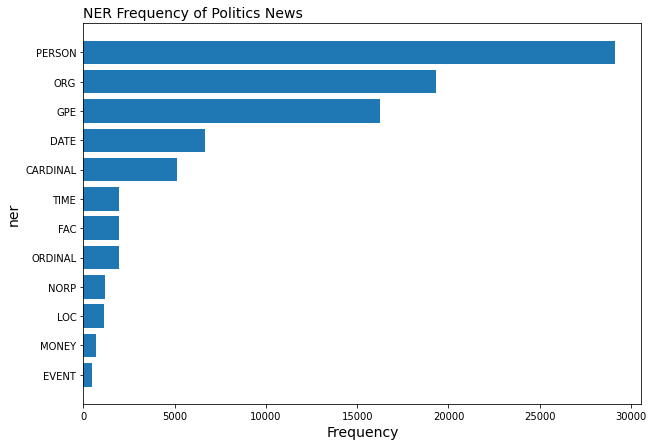

In [ ]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of Politics News',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

(2) 社會版

In [ ]:
# 讀取已經執行完畢的結果
# 社會版
pos_table = pd.read_csv("data/soceity_table/pos_table_society.csv") 
entity_table = pd.read_csv("data/soceity_table/entity_table_society.csv") 
sentence_table = pd.read_csv("data/soceity_table/sentence_table_society.csv") 

In [ ]:
entity_table['ner'].unique()

array(['GPE', 'PERSON', 'DATE', 'FAC', 'TIME', 'LOC', 'ORG', 'MONEY',
       'CARDINAL', 'LAW', 'ORDINAL', 'QUANTITY', 'NORP', 'LANGUAGE',
       'EVENT', 'WORK_OF_ART', 'PRODUCT', 'PERCENT'], dtype=object)

In [ ]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
13,PERSON,20648
11,ORG,7862
4,GPE,6712
1,DATE,4740
16,TIME,4003
0,CARDINAL,3986
8,MONEY,2109
3,FAC,1935
7,LOC,1836
10,ORDINAL,754


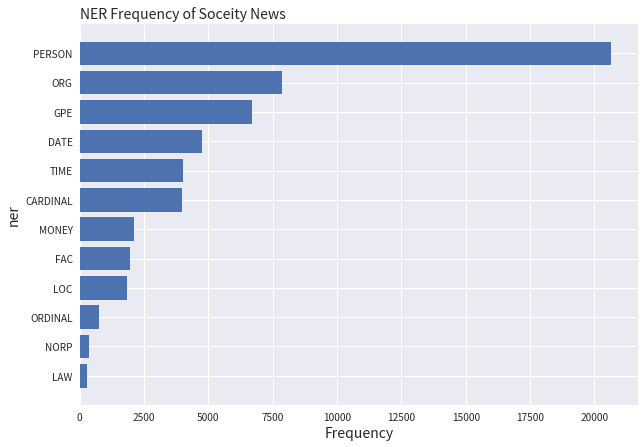

In [ ]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of Soceity News',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的人名(PERSON)

(1) 政治版

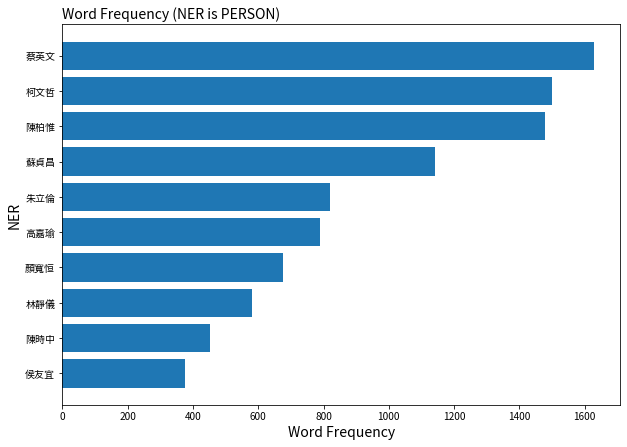

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count


plt.rcParams["font.family"] = "Taipei Sans TC Beta"
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

看一下含特定關鍵字的貼文內容

In [ ]:
keyword_list = ['蔡英文']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

蔡英文：1477篇相關貼文


,id,sentence
21,3.0,中選會日舉行大公投第四場意見發表會，反萊豬公投案的正方代表醫師蘇偉碩對於為何為何這次公投只反...
29,3.0,蘇偉碩強調，可見開放萊牛是朝野兩黨的共識，禁止萊豬全豬也是朝野兩黨的共識，可是如今蔡英文和民...
131,12.0,總統蔡英文
263,28.0,總統蔡英文
322,33.0,包正豪質疑，請大家回想一下，上次總統選舉時，假設投給蔡英文總統，你去投票的時候，你是不是因為...
323,33.0,你去投蔡英文總統的時候到底是投人還是投事
383,38.0,外交部美國國際民主協會立法院日共同舉辦開放國會論壇，總統蔡英文副總統賴清德都出席開幕典禮，日...
416,41.0,而總統蔡英文親頒褒揚令，並向家屬致意外，也獻花三鞠躬致意，同時向李應元的家屬表達慰問
421,41.0,總統蔡英文月日出席李應元告別式，獻花三鞠躬致意
423,41.0,蔡英文執政後，再次邀請他出任環保署署長，並在年月展開第二任任期時，原任駐泰代表童振源返台接任...


In [ ]:
keyword_list = ['柯文哲']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

柯文哲：1347篇相關貼文


,id,sentence
267,28.0,徐巧芯也發現，以帳號與林秉樞本人的政治攻防分析，最常黑的對象包括柯文哲侯友宜盧秀燕，還有民進...
394,39.0,不過，洪偉勝說年公投綁大選的亂象，讓選贏的人，如同台北市長柯文哲贏的不爽快，輸的丁守中輸的不...
476,48.0,有媒體詢問，台灣是獨立自主國家言論是否幫長期被抹紅的台北市長柯文哲解套
672,68.0,徐巧芯發現，以帳號與林秉樞本人的政治攻防分析，最常黑的對象包括柯文哲侯友宜盧秀燕，還有民進黨...
965,88.0,由於名單上素人過半，黨主席柯文哲也責成國家治理學院，盡速舉辦選戰培訓營，協助被提名人學習相關...
967,89.0,台北上海雙城論壇於日登場，由於台北市長柯文哲任期只到年底，明年雙城論壇為最後一次主持，被問到...
968,89.0,柯文哲表示，兩岸雖有隔閡爭議，但要先從沒有爭議的開始進行，上海數位化發展速度快，我們還是要更努力
969,89.0,柯文哲日下午出席台北上海雙城論壇，針對明年將是任期內最後一次雙城論壇，是否會想在兩岸論述上走...
970,89.0,柯文哲回應，還是一樣，你扮演什麼角色，就做什麼事
971,89.0,台北市長柯文哲於雙城論壇後受訪


In [ ]:
keyword_list = ['陳柏惟']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

陳柏惟：1242篇相關貼文


,id,sentence
1160,106.0,立法院向外賓介紹各縣市立委，已遭罷免解職的陳柏惟也被列入
1161,106.0,立法院長游錫堃日下午率朝野立委歡迎開放國會論壇外賓，包括民進黨台灣民眾黨時代力量立委均與會，...
1165,106.0,不過，會中播放介紹國會影片時，卻將已遭罷免解職的陳柏惟納入台中選區立委之一，並放上陳柏惟的照...
1216,113.0,台中第二選區基進黨立委陳柏惟遭罷免，中選會訂明年月投票，國民兩黨分別派前立委顏寬恒林靜儀披掛...
1727,171.0,該幕僚指出，原本國民黨以為罷免台灣基進黨立委陳柏惟後，可趁勢拉抬公投聲勢，但畢竟這四個公投議...
2673,268.0,對此，國民黨文傳會主委凌濤表示，林靜儀打著溫柔堅定的宣傳包裝，但沒多久馬上就露出易怒傲慢本性...
2677,268.0,劉昱佑痛批，民進黨在罷免陳柏惟通過之後，竟然還推出這種比陳柏惟更誇張的候選人，到底把台中在地...
3361,327.0,台中第二選區立委補選將在明年月日進行，民進黨候選人林靜儀對上地方實力紮實的國民黨候選人顏寬恒...
3362,327.0,林靜儀接受資深媒體人黃光芹網路節目新聞不芹菜專訪，林靜儀表示，前基進黨立委陳柏惟當初也是挾帶...
3371,327.0,林靜儀說，有很多人跟她透露希望改變，過去對於地方政治覺得很無助無奈缺乏改變的可能，但在陳柏惟...


In [ ]:
keyword_list = ['高嘉瑜','林秉樞']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

高嘉瑜 林秉樞：741篇相關貼文


,id,sentence
0,0.0,外界質疑民進黨立委高嘉瑜為何被男友林秉樞家暴後，沒在第一時間報警，還在月日參加林秉樞母親的告...
1,0.0,對此，高嘉瑜的前男友馬文鈺今爆料，林秉樞除了找金融鉅子和政界高層向鏡週刊施壓，還威脅高嘉瑜不...
2,0.0,馬文鈺在政論節目辣新聞表示，林秉樞一直跟高嘉瑜要求一件事，這種事情，天知地知，妳知我知，只要...
4,0.0,馬文鈺指出，林秉樞動不動就威脅殺人，月日之前還不知道這個人，日之後林秉樞說要殺他全家，還具名...
5,1.0,黃揚明揭露，有網友發現高嘉瑜在進行節目直播時，出現則疑似網軍的詭異斗內
6,1.0,圖翻攝自黃揚明，下同立委高嘉瑜遭到男友林秉樞施暴幽禁天，但對方手上握有私密影片，高嘉瑜坦言若...
7,1.0,對此，資深媒體人黃揚明日爆料，有熱心網友提供訊息指出，高嘉瑜在進行節目新聞大白話直播時，出現...
9,1.0,黃揚明日晚間在臉書發文表示，一位新聞大白話的網友提供訊息指出，在月日下午的節目中，當天高嘉瑜...
10,1.0,黃揚明貼出截圖顯示，第一則是署名蔡正維的網友斗內元，留言高嘉瑜妳自己想清楚，想不想爆料
11,1.0,第二則是署名邱宜珍的網友斗內元，留言高嘉瑜，妳私人不堪的事情，想要被公開嗎


在政治類新聞中，最多的是「蔡英文」的1477篇，多為公投、反萊豬、典禮、儀式等相關話題。其次為1347篇的「柯文哲」，較多為台北上海雙城論壇等兩岸議題及選舉議題。第三名是「陳柏惟」的1242篇，話題圍繞在罷免相關議題。而「高嘉瑜」、「林秉樞」共有741篇相關貼文，由於家暴案件不斷延燒，導致近期的新聞數量特別多。

(2) 社會版

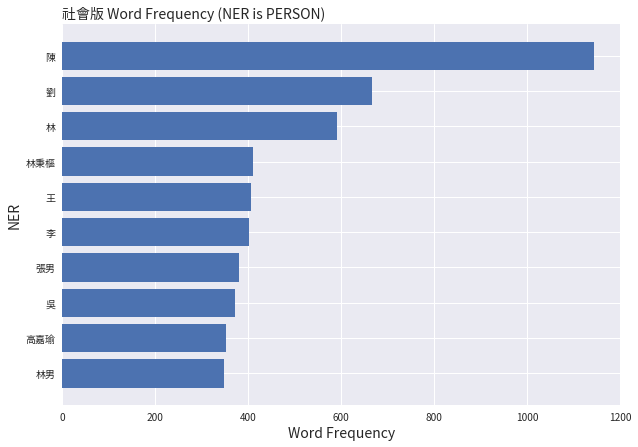

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count


plt.rcParams["font.family"] = "Taipei Sans TC Beta"
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('社會版 Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [ ]:
keyword_list = ['高嘉瑜','林秉樞']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

高嘉瑜 林秉樞：472篇相關貼文


,id,sentence
23,1,高嘉瑜遭男友林秉樞施暴毆打囚禁躍上新聞版面
24,1,壓力下出面自清，但日晚間從到時包含政黑板八卦版又出現網軍抹黑文，指涉高嘉瑜愛拍性愛影片現在情...
25,1,高嘉瑜自拍性愛影片
27,1,立委高嘉瑜日晚間指出，再現惡意網軍攻擊檢討被害人，她相當傻眼無奈
28,1,上述疑似網軍操作爭議檢討被害人言論再現，高嘉瑜陣營日晚間指出，顯示網軍對她的影射抹黑不斷網軍...
29,1,立委高嘉瑜陣營指出，陸續從今晚時分到時分，分別在該論壇政治黑特版八卦版文指涉立委高嘉瑜遭家暴...
30,1,高嘉瑜自拍性愛影片
32,1,立委高嘉瑜日晚間指出，再現惡意網軍攻擊檢討被害人，她相當傻眼無奈
33,1,原本看似網友閒聊討論八卦的文，卻被眼尖者發現，組帳號從今晚時許密集文，而且使用的都是新聞播報...
34,1,眼尖網友發現後向立委高嘉瑜陣營反映，指個帳號在短短小時內的個文，都使用同一組新聞截圖


在社會版新聞當中，常常會以「X某」、「X姓」、「X先生／小姐」來代稱，所以可以看到「陳」、「劉」、「林」被提及的次數相對的多。而「林秉樞、高嘉瑜」的家暴事件共有472篇，討論聲量相當高，新聞數量也有不少。此事件在政治版中也有出現，原因是高嘉瑜是民進黨立委。

### 涉及到的組織(ORG)

(1) 政治版

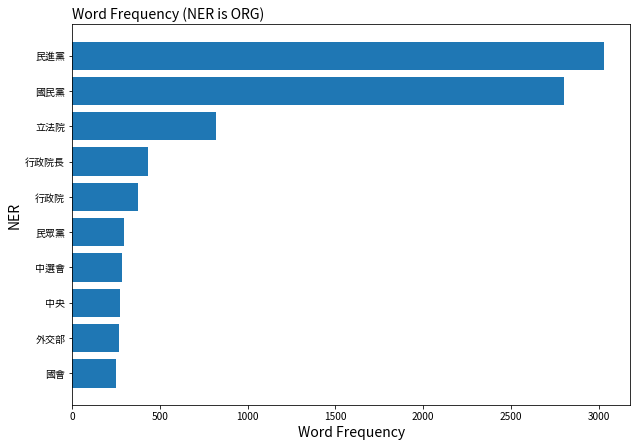

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

前三名分別是「民進黨」、「國民黨」與「立法院」，因為是執政黨與在野黨所以被報導的次數相較其他政黨多，而民眾也時常會關注立法院的動向。

(2) 社會版

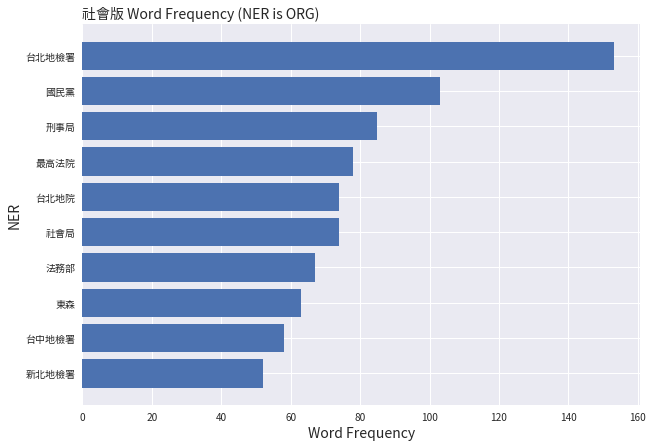

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('社會版 Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

因為是社會版的關係，所以可以看到「台北地檢署」、「刑事局」、「最高法院」等字詞，在文章裡出現的次數都是較多的。

### 涉及到的民族、宗教、政治團體(NORP)

(1) 政治版

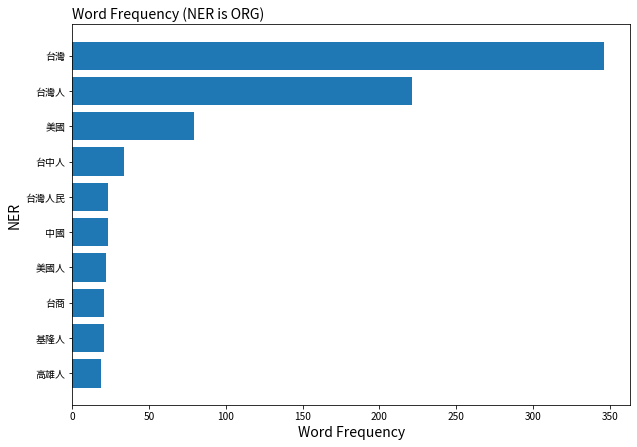

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [ ]:
keyword_list = ['台灣','美國']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

台灣 美國：4072篇相關貼文


,id,sentence
22,3.0,針對政府宣稱反萊豬公投若通過將重傷台灣經貿發展，且泰國歐盟都有先例
26,3.0,蘇偉碩說，美國之所取消泰國/的零關稅優惠，是因為年，一個人口高達萬人口的泰國，一整年只進口了...
34,4.0,民進黨團幹事長劉世芳則說，國民黨團近期停審明年度總預算案，背後動機就是，不希望台灣能夠製作量...
38,4.0,劉世芳則說，國民黨主席朱立倫近期要求國民黨立委要支持公投案，用盡各種方法，全力杯葛部會預算，...
39,4.0,至於藍營質疑海空戰力提升計畫採購特別條例違反財政紀律，劉世芳解釋，該特別條例攸關項國造武器系...
52,5.0,也呼籲國民黨不要把公投當作政治鬥爭的工具，讓台灣繼續亂下去
53,5.0,許嘉恬表示，自今年月日衛福部國民健康署推出不孕症治療補助方案後，已有超過一萬件申請案通過資格...
54,5.0,許嘉恬表示，請蔣萬安苦民所苦，不要跟國民黨朱立倫一起墮落，為了政治鬥爭而卡住台灣下一代不孕症的問題
57,6.0,對此，台灣民意基金會董事長游盈隆表示，他基層的一位朋友好奇，林秉樞為何這麼快被抓起來
94,9.0,謝佩芬指出，正方代表以己烯雌酚來類推開放萊克多巴胺美豬會造成人體傷害，事實上，萊克多巴胺是在...


In [ ]:
keyword_list = ['台中人']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

台中人：37篇相關貼文


,id,sentence
5305,528.0,顏清標與顏寬恒一家，把台中人的肺當印鈔機
5662,564.0,資深媒體人周玉蔻昨引述台中市議員陳世凱爆料，控國民黨台中第二選區參選人顏寬恒家庭搶下台中港煤...
5668,564.0,對此，周玉蔻日一早則以夭壽喔，台中人的肺台中人的命，竟然是顏寬恒家族擁抱紅派張家溫暖賺大錢的印鈔機
5674,564.0,台中人的肺台中人的命竟然成為你家的印鈔機
5907,582.0,資深媒體人周玉蔻狂打前立委顏寬恒家產，日引述市議員陳世凱爆料，批顏家搶下台中港煤炭倉儲案是罔...
5910,582.0,資深媒體人周玉蔻近日屢轟前立委顏寬恒一家房產財務爭議，她今天引述台中市議員陳世凱的爆料，批顏...
6395,620.0,資深媒體人周玉蔻近日屢轟前立委顏寬恒一家房產財務爭議，她今引述台中市議員陳世凱的爆料，批顏家...
6397,620.0,周玉蔻日一早在臉書表示，顏寬恒一家為了利益鈔票，居然不顧台中人死活，硬是阻擋台電中火燃煤機組...
6403,620.0,台中人的肺呢
6404,620.0,台中人乾淨的空氣呢


「台灣」、「美國」共有4072篇相關新聞，可以明顯看出多為反萊豬、公投、政治鬥爭等相關議題。而排名第四高的「台中人」，是被顏清標、顏寬恒相關話題帶動的熱度。

(2) 社會版

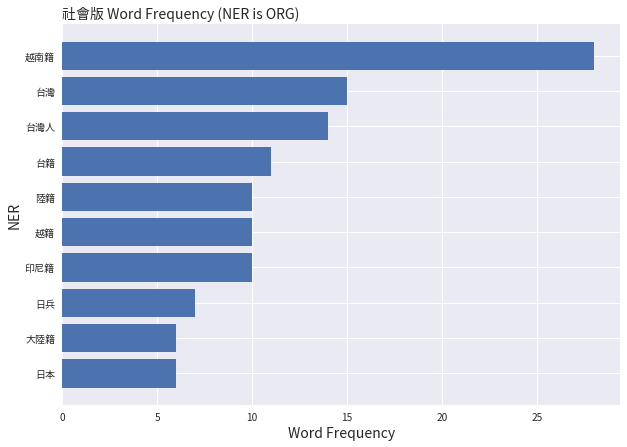

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('社會版 Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [ ]:
keyword_list = ['越南籍','台籍']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

越南籍 台籍：38篇相關貼文


,id,sentence
1408,145,桃園市新屋區後湖區防風林發生越南籍逃逸吳姓女移工命案，圖為案發現場防風林
1409,145,桃園市新屋區後湖溪出海口防風林今年月間發現越南籍女屍案，檢警抽絲剝繭查出設籍新北市王姓男子涉...
1412,145,涉嫌持石塊砸死越南籍逃逸吳姓女移工命案，楊梅警方在現場蒐證
1413,145,檢警查出，死者是在新北市某工廠工作的歲越南籍失聯女移工，來台工作年多，上月底與工廠歲男同事王...
1414,145,涉嫌持石塊砸死越南籍逃逸吳姓女移工命案，新北市籍王姓男子遭楊梅警分局緝捕到案
3749,633,越南籍移工范姓男子，懷疑被越南妻劉女戴綠帽，竟持公分料理刀趁妻不注意朝胸口猛刺刀
3752,633,汐止警日晚間時許獲報，汐止區福德一路巷內一處貨櫃屋發生凶殺案，警火速抵達現場，發現歲越南籍劉...
3753,633,警方通知劉姓雇主發現行凶者是越南籍移工范姓丈夫，范嫌刺死妻子後，跑回移工宿舍企圖持菜刀自殘，...
4090,715,新北市汐止區福德一路昨日深夜時許發生一起凶殺命案，警方初步調查，一名越南籍男子疑似懷疑越南籍...
6208,1330,疫情降級警戒後部分特種行業開始蠢蠢欲動違規經營，北市內湖警方接獲線報，指稱成功路有越南籍女子...


「越南籍」、「台灣」共有38篇相關新聞，此為越南籍失聯女移工命案議題。

## 3.4 探索分析 - POS

### POS 種類分析
查看辨識出哪幾種POS

In [ ]:
pos_table['pos'].unique()

array(['Ncd', 'VE', 'Nb', 'Na', 'D', 'P', 'Ng', 'COMMACATEGORY', 'Neu',
       'VA', 'Nd', 'VC', 'DE', 'Nh', 'VF', 'VK', 'Nep', 'Nes', 'Caa',
       'Nc', 'VB', 'Cbb', 'VH', 'VJ', 'Neqa', 'Di', 'Dfa', 'VG', 'Nf',
       'VI', 'SHI', 'T', 'VD', 'Cba', 'VCL', 'VHC', 'V_2', 'Cab', 'Dk',
       'A', 'Da', 'FW', 'VAC', 'Dfb', 'VL', 'Neqb', 'Nv', 'PAUSECATEGORY',
       'I', 'PARENTHESISCATEGORY', 'DM', 'PERIODCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

(1) 政治版

In [ ]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

,pos,count
15,Na,165691
5,D,72992
36,VC,65053
17,Nc,49351
16,Nb,39362
42,VH,37542
29,P,35831
6,DE,29423
39,VE,29397
33,VA,21836


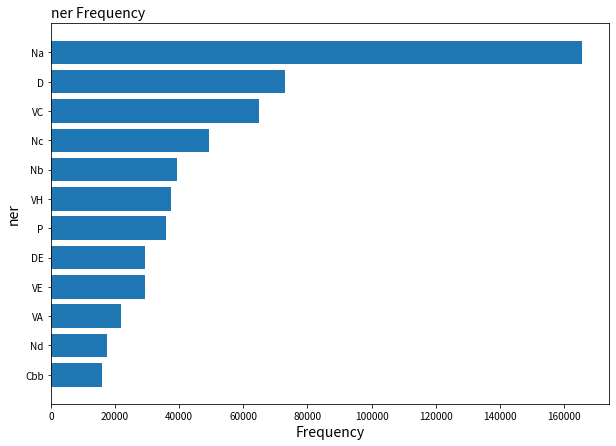

In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

POS 詞性列表:
* 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
  * Na: 普通名詞
  * D: 副詞
  * VC: 動作及物動詞
  * Nb: 專有名詞
  * FW: 外文
  * VH: 狀態不及物動詞
  * Nh: 代名詞
  * DE: 的之得地
  * P: 介詞
  * VA: 動作不及物動詞
  * T: 語助詞
  * SHI: 是

(2) 社會版

In [ ]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

,pos,count
15,Na,166005
35,VC,67001
5,D,60101
17,Nc,44185
29,P,39337
41,VH,34779
16,Nb,28548
32,VA,27646
38,VE,24864
25,Nf,16532


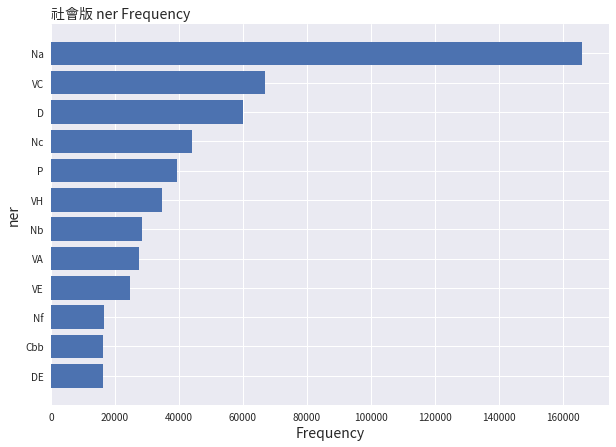

In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('社會版 ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

可以看出政治版與社會版都是普通名詞居多，副詞、動詞分別位居二、三名。

### 涉及到的名詞(Na)
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

(1) 政治版

In [ ]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
# 寫法一
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count.head(10)

,word,count
0,民進黨,3163
1,國民黨,3063
2,蔡英文,1628
3,柯文哲,1513
4,陳柏惟,1486
5,蘇貞昌,1156
6,朱立倫,825
7,高嘉瑜,791
8,顏寬恒,687
9,林靜儀,586


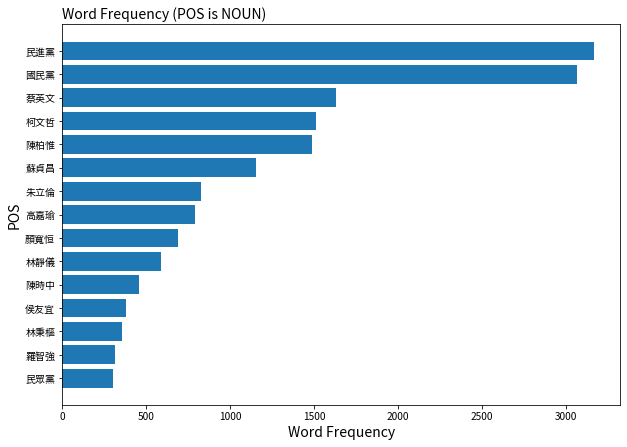

In [ ]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到政治新聞中，「民進黨」、「國民黨」討論度不相上下，而總統「蔡英文」也是報導的焦點，另外還有「柯文哲」、「陳柏維」、「蘇貞昌」、「朱立倫」等政治人物，而「高嘉瑜」因家暴事件，近期討論量很高。

(2) 社會版

In [ ]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
# 寫法一
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count.head(10)

,word,count
0,林男,671
1,陳姓,557
2,張男,553
3,陳男,524
4,林秉樞,417
5,黃男,374
6,高嘉瑜,355
7,李男,342
8,劉男,340
9,林姓,329


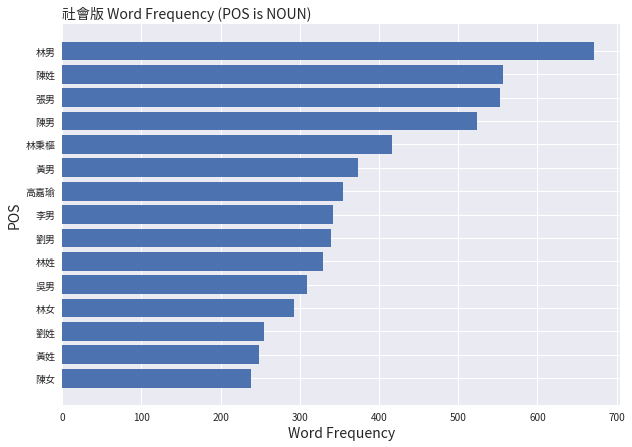

In [ ]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('社會版 Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到在社會版的新聞當中，「林」、「陳」等姓是較常出現在社會新聞上的，那這裡也出現了高嘉瑜、林秉樞。

### 涉及到的動詞(VERB)
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

(1) 政治版

In [ ]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'] \
                                 .count() \
                                 .reset_index(name='count') \
                                 .sort_values(['count'], ascending=False) \
                                 .head(15)
verb_count

,word,count
2417,相關,999
1104,安全,682
3131,這樣,660
3250,重要,483
2241,特別,452
704,合作,398
92,不同,372
551,努力,336
14,一樣,285
2762,自由,258


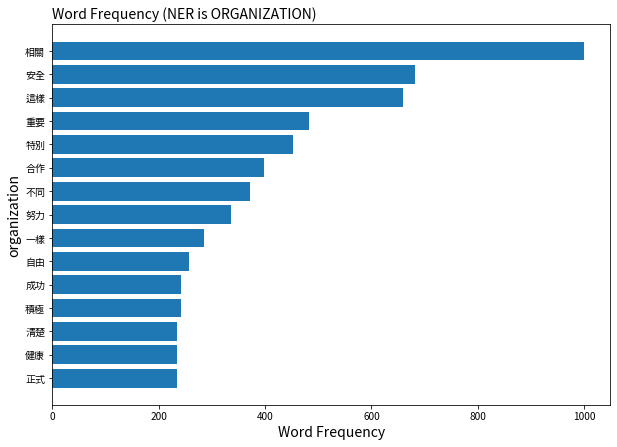

In [ ]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [ ]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['相關','安全']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

相關 安全：1564篇相關貼文


,id,sentence
14,1.0,尤其隔天日高嘉瑜就到板橋的飯店與林會面而發生施暴事件，這是否相關
33,4.0,國民黨團書記長陳玉珍日受訪表示，明天將有相關動作，表達國民黨團的立場，並批不要用抗中保台的大...
35,4.0,陳玉珍今天受訪表示，國民黨團明天將會有相關動作，表達自身立場
51,5.0,對此，許嘉恬表示，中央政府總預算攸關重大國家建設民生經濟社會福利的相關預算，其中也包含幼托津...
95,9.0,另外，謝佩芬也說，正方代表又拿神經退化疾病的狂牛症與動物飼料用藥萊克多巴胺做類比，把兩者完全...
98,9.0,謝佩芬強調，食品安全是科學問題，絕不是政治問題，應以國際標準和科學驗證作為立論基礎，國民黨不...
103,10.0,另外，在該則文中所提供的核安相關資料圖卡也被網友質疑核四年前的設備你跟我說先進不是核四廠下面...
104,10.0,國民黨在昨日臉書文中附上四張關於核四的圖卡，重申核四廠安全無慮，希望網友與民眾能支持同意重啟核四
108,10.0,核四廠品管不安全
114,10.0,核四廠是拼裝車所以不安全


In [ ]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['重要','特別']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

重要 特別：898篇相關貼文


,id,sentence
9,1.0,黃揚明日晚間在臉書發文表示，一位新聞大白話的網友提供訊息指出，在月日下午的節目中，當天高嘉瑜...
32,4.0,立法院日將邀請行政院長蘇貞昌赴立法院，報告中央政府海空戰力提升計畫採購特別預算案並備質詢，由...
36,4.0,她強調，大家都支持編列軍購預算，不過，該預算案有空白授權違反財政紀律的疑慮，海空戰力提升計畫...
38,4.0,劉世芳則說，國民黨主席朱立倫近期要求國民黨立委要支持公投案，用盡各種方法，全力杯葛部會預算，...
39,4.0,至於藍營質疑海空戰力提升計畫採購特別條例違反財政紀律，劉世芳解釋，該特別條例攸關項國造武器系...
138,13.0,蔡炳坤認為，以台北市來說，北市大型醫院非常多，且此次預約情況不理想，所以比較贊同盡量回歸到醫...
271,29.0,高嘉瑜特別點名資深媒體人周玉蔻前立委謝欣霓，很多過去不喜歡我的人，都還是願意給我力量挺身而出...
272,29.0,特別要感謝這幾天媒體朋友們的幫忙，不斷挖掘真相
278,29.0,喜好此道則生存，不喜則離去，高嘉瑜今天特別在臉書謝謝我對她正義的支持
321,33.0,包正豪認為，公投很重要要仔細考慮，公投是對事的選舉一般選舉是對人的選舉，人跟事不一樣，所以單...


使用第一、二名的「相關」與「安全」來看相關新聞議題，發現有高嘉瑜家暴案、食安問題、核四等。此外，第三、四名的「重要」、「特別」則大多數為國防安全議題，亦有少數公投話題，顯示國安方面的關注與重要性。

(2) 社會版

In [ ]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'] \
                                 .count() \
                                 .reset_index(name='count') \
                                 .sort_values(['count'], ascending=False) \
                                 .head(15)
verb_count

,word,count
2435,相關,679
520,到案,502
1815,死亡,484
1029,安全,420
612,受傷,356
2635,緊急,347
776,嚴重,321
232,事發,315
139,不治,313
484,出現,295


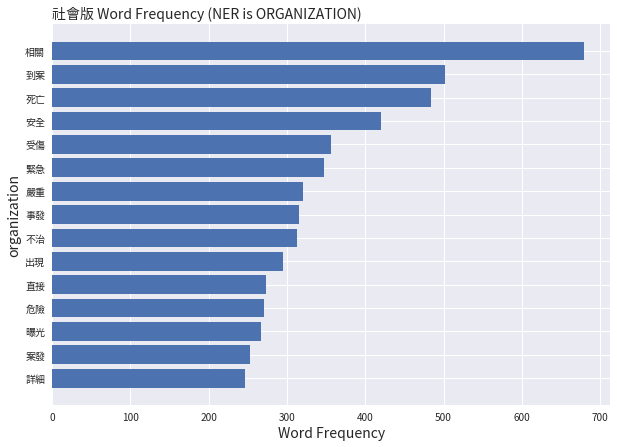

In [ ]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('社會版 Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在社會新聞當中的動詞，「到案」、「死亡」佔了相當高的頻率，可以看出有很多案件是要到案做說明，以及也有不少跟死亡有關的新聞。

In [ ]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['到案','死亡','安全']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

到案 死亡 安全：1432篇相關貼文


,id,sentence
1,0,警方獲報後，循線將林男擒獲到案
112,10,對此，台中地檢署已經介入調查，並傳喚名里長位里民到案說明
114,10,本署檢察官於今日指揮法務部調查局台中市調查處台中市政府警察局，分別通知及傳訊相關里長及里民到...
166,16,曾男到案後坦承犯行，法官痛斥曾為逞獸慾，假借鬼神之說對女子性侵，造成女子精神受創，審結依強制...
180,17,台北富邦銀行總經理程耀輝與會指出，防阻詐騙守護客戶財產安全是銀行的天職，為能替客戶資產做最好...
182,17,北富銀強調在該行資安長蘇清偉領導下，將在金融科技上持續導入風險控管和科技徵信機制，同步提升客...
186,17,對富邦銀願率先運用前瞻金融科技，積極與刑事局攜手合作表達敬佩之意，期望刑事局與北富銀共同投入...
258,25,台中市第二警分局表示，育才派出所警員陳倚文陳益弘月日晚間時許，巡邏經過北區三民路與太平路口時...
263,26,桃園市吳姓男子懷疑妻子外遇，吳疑似徒手毆打妻子後再以棉被摀住口鼻致死，檢警預計日下午解剖確認...
309,29,前女友最後決定向警方報案，林秉樞向辦案人員辯稱，前女友應該不會因此心生畏懼，最後被檢察官依恐...


「到案」、「死亡」、「安全」共有1432篇新聞，有詐騙、高嘉瑜家暴案、外遇等社會案件。

## 4. 利用SnowNLP進行情緒分析

In [ ]:
sentence_table.head() # sentence 列表

,id,sentence
0,0.0,外界質疑民進黨立委高嘉瑜為何被男友林秉樞家暴後，沒在第一時間報警，還在月日參加林秉樞母親的告...
1,0.0,對此，高嘉瑜的前男友馬文鈺今爆料，林秉樞除了找金融鉅子和政界高層向鏡週刊施壓，還威脅高嘉瑜不...
2,0.0,馬文鈺在政論節目辣新聞表示，林秉樞一直跟高嘉瑜要求一件事，這種事情，天知地知，妳知我知，只要...
3,0.0,一個受傷都還沒痊癒的人
4,0.0,馬文鈺指出，林秉樞動不動就威脅殺人，月日之前還不知道這個人，日之後林秉樞說要殺他全家，還具名...


In [ ]:
from snownlp import SnowNLP
s = SnowNLP('林秉樞一直跟高嘉瑜要求一件事')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.732347020085368

In [ ]:
from snownlp import SnowNLP
s = SnowNLP('此次預約情況不理想')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.22113285783680825

In [ ]:
# 社會版
from snownlp import SnowNLP
s = SnowNLP('年約歲的林男前年月日晚間時許在中壢區某小北百貨購得菜刀把')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.951662876017944

將句子和日期合併，方便之後做分析

(1) 政治版

In [ ]:
news_df = pd.read_csv("./raw_data/MetaData_politics.csv") #匯資料

sentiment_date = pd.merge(sentence_table,news_df[['id','artDate']],on='id',how='left')
sentiment_date.head(3)

,id,sentence,artDate
0,0.0,外界質疑民進黨立委高嘉瑜為何被男友林秉樞家暴後，沒在第一時間報警，還在月日參加林秉樞母親的告...,2021/12/2 23:26
1,0.0,對此，高嘉瑜的前男友馬文鈺今爆料，林秉樞除了找金融鉅子和政界高層向鏡週刊施壓，還威脅高嘉瑜不...,2021/12/2 23:26
2,0.0,馬文鈺在政論節目辣新聞表示，林秉樞一直跟高嘉瑜要求一件事，這種事情，天知地知，妳知我知，只要...,2021/12/2 23:26


In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(5)

,id,sentence,artDate,sentimentValue
0,0.0,外界質疑民進黨立委高嘉瑜為何被男友林秉樞家暴後，沒在第一時間報警，還在月日參加林秉樞母親的告...,2021/12/2 23:26,0.808762
1,0.0,對此，高嘉瑜的前男友馬文鈺今爆料，林秉樞除了找金融鉅子和政界高層向鏡週刊施壓，還威脅高嘉瑜不...,2021/12/2 23:26,0.999226
2,0.0,馬文鈺在政論節目辣新聞表示，林秉樞一直跟高嘉瑜要求一件事，這種事情，天知地知，妳知我知，只要...,2021/12/2 23:26,0.987940
3,0.0,一個受傷都還沒痊癒的人,2021/12/2 23:26,0.319843
4,0.0,馬文鈺指出，林秉樞動不動就威脅殺人，月日之前還不知道這個人，日之後林秉樞說要殺他全家，還具名...,2021/12/2 23:26,0.988183


In [ ]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe() 

count    25487.000000
mean         0.356053
std          0.389564
min          0.000000
25%          0.004520
50%          0.149703
75%          0.762364
max          1.000000
Name: sentimentValue, dtype: float64

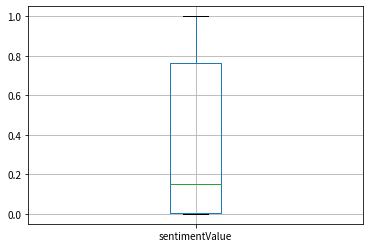

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

情緒平均偏低，負面情緒較多，可能新聞報導內容大多數比較負面

將每天的情緒分數取平均，並轉換時間格式為天

In [ ]:
sentiment_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.date
sentiment_count = sentiment_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2021-10-05,0.360479
1,2021-10-08,0.439567
2,2021-10-09,0.398741
3,2021-10-10,0.474294
4,2021-10-13,0.436327
5,2021-10-14,0.380872
6,2021-10-15,0.302676
7,2021-10-16,0.357022
8,2021-10-17,0.489098
9,2021-10-18,0.359100


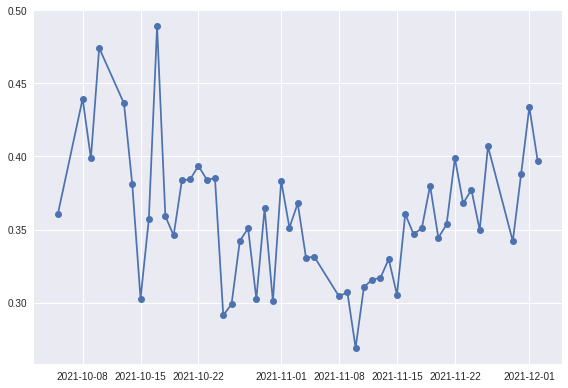

In [ ]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

(2) 社會版

In [ ]:
society_df = pd.read_csv("./raw_data/MetaData_society (1).csv") #匯資料

sentiment_date = pd.merge(sentence_table,society_df[['id','date']],on='id',how='left')
sentiment_date.head(3)

,id,sentence,date
0,0,桃園市林姓男子前年月在中壢區某路段，持菜刀向不認識路人大喊賣造，連續對大馬路上名機車騎士喝令...,2021/12/2 23:25
1,0,警方獲報後，循線將林男擒獲到案,2021/12/2 23:25
2,0,桃園地院審理時，林辯稱當天碰到仇家，為躲避才向騎士借車，但法官綜合名被害人指證，認為林犯行明...,2021/12/2 23:25


In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(5)

,id,sentence,date,sentimentValue
0,0,桃園市林姓男子前年月在中壢區某路段，持菜刀向不認識路人大喊賣造，連續對大馬路上名機車騎士喝令...,2021/12/2 23:25,0.985048
1,0,警方獲報後，循線將林男擒獲到案,2021/12/2 23:25,0.549015
2,0,桃園地院審理時，林辯稱當天碰到仇家，為躲避才向騎士借車，但法官綜合名被害人指證，認為林犯行明...,2021/12/2 23:25,0.001056
3,0,但攜帶凶器強盜罪與未遂分別判處年月年月徒刑，應執行有期徒刑年，仍可上訴,2021/12/2 23:25,0.069703
4,0,檢警調查，年約歲的林男前年月日晚間時許在中壢區某小北百貨購得菜刀把，當晚時分許，在中壢區某路...,2021/12/2 23:25,0.002653


In [ ]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe() 

count    22946.000000
mean         0.363793
std          0.390357
min          0.000000
25%          0.004546
50%          0.169791
75%          0.774503
max          1.000000
Name: sentimentValue, dtype: float64

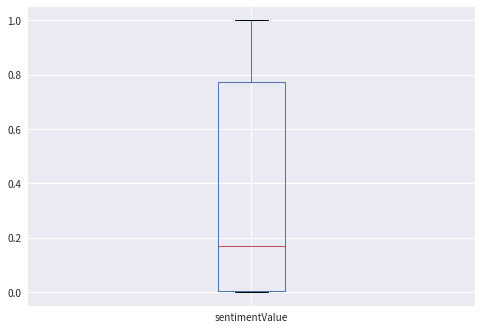

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [ ]:
sentiment_date['date'] =  pd.to_datetime(sentiment_date['date']).dt.date
sentiment_count = sentiment_date.groupby(['date'])['sentimentValue'].mean().reset_index()
sentiment_count

,date,sentimentValue
0,2021-10-01,0.307515
1,2021-10-02,0.381150
2,2021-10-03,0.442559
3,2021-10-04,0.344877
4,2021-10-05,0.360305
...,...,...
58,2021-11-28,0.350468
59,2021-11-29,0.385393
60,2021-11-30,0.388574
61,2021-12-01,0.399307


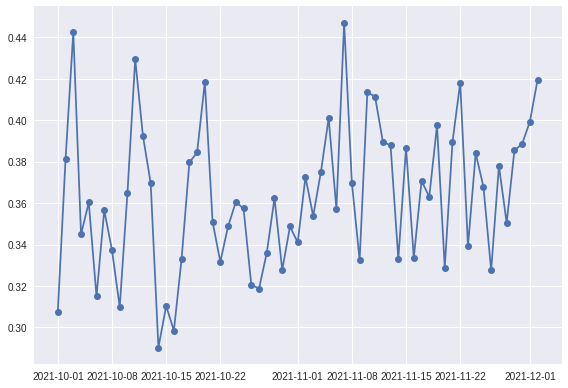

In [ ]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['date']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

實際上，政治版和社會版的平均情緒都偏低，而社會版的情緒起伏比較大。

### 正面詞彙探索
(1) 政治版

從上圖中可以發現 10/10 和 10/11 的情緒比較高，我們把那兩天的正面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖我們可以發現，文中句子的情緒值大部分偏低，平均大概在0.15左右。臨界點取稍微高一點，選情緒值選0.4以上的句子。

In [ ]:
# 篩時間區間
startdate = pd.to_datetime("2021-10-10").date()
enddate = pd.to_datetime("2021-10-11").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] >= 0.6]

# 看一下正面句子都在討論甚麼
filter_sentiment.head(5)

,id,sentence,artDate,sentimentValue
24029,2352.0,陸委會提到，總統在國慶談話強調面對情勢嚴峻挑戰，台灣堅定貢獻區域和平捍衛民主自由,2021-10-10,0.857552
24031,2352.0,陸委會指出，總統談話展現兩岸政策的一貫性，傳達台灣萬人民堅定的決心意志，更籲北京當局揚棄敵意...,2021-10-10,0.922067
24036,2353.0,總統蔡英文發表國慶講說,2021-10-10,0.882381
24037,2353.0,今天是中華民國年國慶，總統蔡英文上午發表國慶演說，針對兩岸議題提出個堅持，堅持自由民主的憲政...,2021-10-10,0.872446
24039,2353.0,蔡英文今天在國慶典禮演說時直指，當我們越好，中國給我們的壓力就越大,2021-10-10,0.970631


In [ ]:
# 把時間分數和之前斷詞的token table做 join
positive_words = pd.merge(filter_sentiment,pos_table,on='id',how='left')
positive_words = positive_words[['id','sentimentValue','word']]
positive_words.head(5)

,id,sentimentValue,word
0,2352.0,0.857552,對岸
1,2352.0,0.857552,國台
2,2352.0,0.857552,辦
3,2352.0,0.857552,日
4,2352.0,0.857552,晚間


In [ ]:
# 篩選只有單個字元的結果
positive_words = positive_words[positive_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [ ]:
# 自定停用字
with open('./dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['\ufeff,', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '[', ']', '「', '」', '\\n', '\\u3000', ' ', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '俺', '俺們', '按', '按照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '衝', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '譁', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', '繼而'

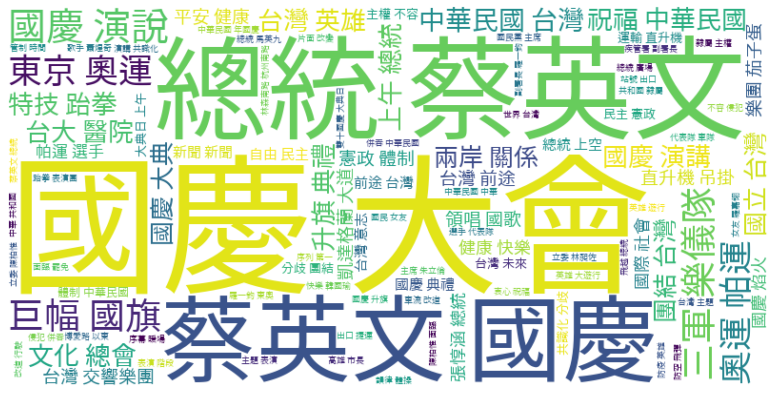

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('更多','相關','時分','以北'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = './TaipeiSansTCBeta-Regular.ttf'
plt.rcParams["font.family"] = "Taipei Sans TC Beta"

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(positive_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

在10/10、10/11這兩天，恰逢國慶日，因此新聞報導多為正面情緒，在文字雲中也可以明顯看到「國慶大會」、「總統蔡英文」等詞彙，還有一些與國慶大典相關的「三軍樂儀隊」、「直升機」、「升旗典禮」與「祝福」等。



(2) 社會版

從上圖中可以發現 10/02 和 11/07 的情緒特別高，我們把那兩天的正面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖我們可以發現，文中句子的情緒值大部分偏低，平均大概在0.2左右，臨界點取高一點，選情緒值選0.6以上的句子。

In [ ]:
# 篩時間區間
startdate = pd.to_datetime("2021-10-02").date()
enddate = pd.to_datetime("2021-11-07").date()
filter_sentiment = sentiment_date[sentiment_date.date.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] >= 0.6]

# 看一下正面句子都在討論甚麼
filter_sentiment.head(5)

,id,sentence,date,sentimentValue
9462,2016,花蓮秀林鄉羊頭山日發生山難死傷意外，國防醫學院的歲蔡姓男學生疑似未申請到入園證，跟朋友一起攀...,2021-11-07,0.997915
9464,2016,據悉，廖姓男子預計日獨自攀登羊頭山，但出發時臨時帶上未申請入園的蔡姓男子及吳姓男子，於日凌晨...,2021-11-07,0.878589
9465,2016,沒想到，蔡男在清晨時分許在邊坡處摔落公尺深的山谷中,2021-11-07,0.998108
9466,2016,同行友人目睹蔡男摔落，發現蔡男跌落時面部瘀青有血，呼叫無反應，疑似頭部重創而失去生命跡象,2021-11-07,0.999103
9470,2017,高雄一名歲黃姓女子日凌晨酒駕騎車，由於未開車燈又邊滑手機，被巡邏員警攔下，沒想到黃女因此直接嚇哭,2021-11-07,0.914439


In [ ]:
# 把時間分數和之前斷詞的token table做 join
positive_words = pd.merge(filter_sentiment,pos_table,on='id',how='left')
positive_words = positive_words[['id','sentimentValue','word']]
positive_words.head(5)

,id,sentimentValue,word
0,2016,0.997915,花蓮
1,2016,0.997915,秀林鄉
2,2016,0.997915,羊頭山日
3,2016,0.997915,發生
4,2016,0.997915,山難


In [ ]:
# 篩選只有單個字元的結果
positive_words = positive_words[positive_words.apply(lambda x: len(x['word'])>1, axis=1)]

**正面詞彙文字雲**

In [ ]:
# 自定停用字
with open('./dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['\ufeff,', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '[', ']', '「', '」', '\\n', '\\u3000', ' ', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '俺', '俺們', '按', '按照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '衝', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '譁', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', '繼而'

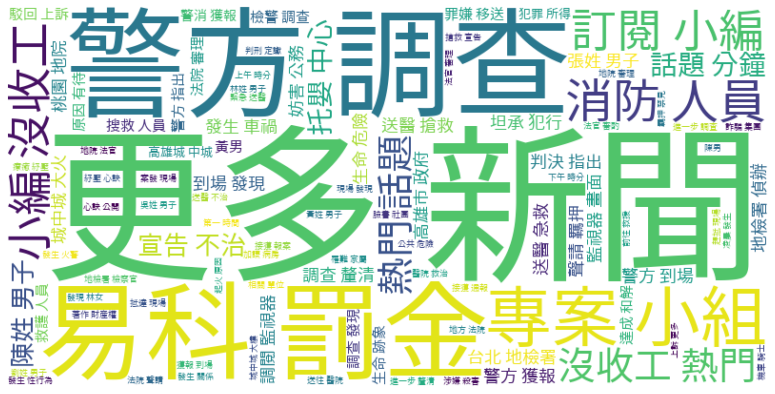

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('羊頭山','國防醫學院','蔡男','吳男','秀林鄉'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'
plt.rcParams["font.family"] = "Taipei Sans TC Beta"

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(positive_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

在正面情緒的句子中，從「警方」、「調查」、「易科」、「罰金」等詞彙，可以看出警察有在介入調查，也有做出應有的懲處。

### 負面詞彙探索

(1) 政治版


從上圖中可以發現 11/10 的情緒特別低，我們把那天的負面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖，我們選取情緒值小於0.2的句子。

In [ ]:
# 篩時間區間
# sentiment_date.loc[sentiment_date.to_datetime(['2021-09-17', '2010-01-04'])]

date1 = pd.to_datetime('2021-11-09').date()
date2 = pd.to_datetime("2021-11-10").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.isin([date1,date2])]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.2]

# 看一下負面句子都在討論甚麼
filter_sentiment[5:15]

,id,sentence,artDate,sentimentValue
11157,1071.0,今年月日將有大公投案舉行，國民黨主席朱立倫向總統蔡英文下戰帖辯論，但蔡英文至今未回應,2021-11-10,0.006977
11159,1071.0,朱立倫表示，我跟蔡總統下戰帖已經不是第一天，再次呼籲蔡英文，不要躲在讀稿機之後，不要躲在發言...,2021-11-10,0.041347
11165,1072.0,台中市第選區在前台灣基進立委陳柏惟罷免案通過後，明年月日舉行補選，民進黨在月日徵召林靜儀參加...,2021-11-10,0.000005
11167,1072.0,關於空降參選，她接受媒體聯訪表示，在台中讀書工作年，只是沒有一出生就準備當政治人物，又有名綠...,2021-11-10,0.020857
11168,1072.0,林靜儀指出，立委不可能做到跟里長一樣，應該是系統性的合作，她在當醫生多年後，才當政治人物，對...,2021-11-10,0.007706
11172,1072.0,►按這訂閱小編沒收工每天給你熱門話題分鐘,2021-11-10,0.001096
11173,1073.0,烏日可能是台中第二選區的關鍵決戰點,2021-11-10,0.042374
11174,1073.0,，東海大學政治系教授沈有忠表示，這個選區的選民結構正在改變，在烏日這個地方外來移入人口正在增...,2021-11-10,0.007342
11176,1073.0,►按這訂閱小編沒收工每天給你熱門話題分鐘,2021-11-10,0.001096
11177,1074.0,美國國會議員昨搭乘一架行政專機來台訪問，中共解放軍隨即宣布在東部戰區軍演，今就有架次軍機侵入...,2021-11-10,0.034804


In [ ]:
# 把時間分數和之前斷詞的token table做 join
negative_words = pd.merge(filter_sentiment,pos_table,on='id',how='left')
negative_words = negative_words[['id','sentimentValue','word']]

In [ ]:
# 篩選只有單個字元的結果
negative_words = negative_words[negative_words.apply(lambda x: len(x['word'])>1, axis=1)]

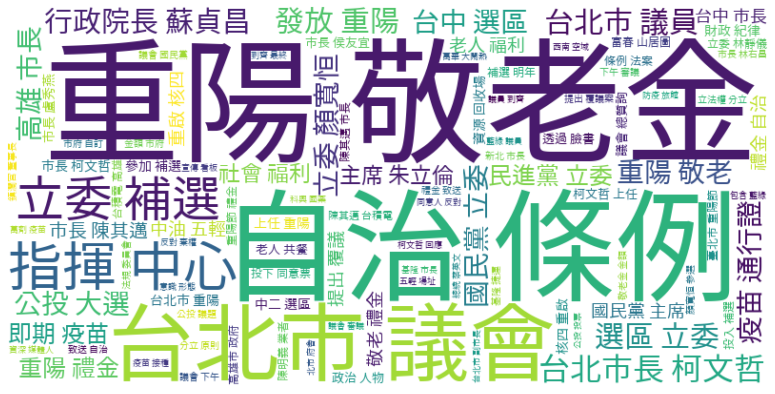

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_neg = stop_words
stop_words_neg.extend(('取消','指出','年元'))
stop_words_neg = set(stop_words_neg)


# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(stopwords=stop_words_neg,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")\
            .generate(' '.join(negative_words['word']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

11/10時，台北市議會通過自治條例，可能有希望重陽敬老金，使報導焦點聚集在此話題上。而推測台北市長柯文哲上任後，停止發放重陽敬老禮金，因此引起民眾的不滿，新聞報導的情緒分析偏向負面。

**負面詞彙探索**


(2) 社會版

In [ ]:
# 篩時間區間
# sentiment_date.loc[sentiment_date.to_datetime(['2021-09-17', '2010-01-04'])]

date1 = pd.to_datetime('2021-10-14').date()
date2 = pd.to_datetime("2021-10-15").date()
filter_sentiment = sentiment_date[sentiment_date.date.isin([date1,date2])]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.2]

# 看一下負面句子都在討論甚麼
filter_sentiment[5:15]

,id,sentence,date,sentimentValue
18574,3807,當晚點多，一群男女約多人到蔡姓保母家撒冥紙丟雞蛋洩憤，警方聞訊到場勸阻，依社會秩序維護法送辦,2021-10-15,0.014343
18575,3807,據了解，一群人不滿保母照顧疏失，又疑似飾詞推託，前往蔡姓保母位在仁武區的住家丟雞蛋撒冥紙抗議...,2021-10-15,0.030242
18577,3807,事後，警方將調閱監視器，逐一通知相關人等到案說明,2021-10-15,0.046812
18578,3807,網友到場丟冥紙放鞭炮洩憤，警員則到場攔阻,2021-10-15,0.011100
18580,3807,不過，彫博疑似不滿警方作法，強調待責任釐清，就會公布保母所有資料，你們警察那邊別想把事情壓小...,2021-10-15,0.002491
18581,3807,你們警方很會保護那些真正的壞人嘛，你們無法還我公道還我一個女兒，我就自己來,2021-10-15,0.069702
18587,3807,►按這訂閱小編沒收工每天給你熱門話題分鐘,2021-10-15,0.001096
18588,3808,城中城大火死傷，檢警調查黃姓女子涉有重嫌,2021-10-15,0.170187
18590,3808,檢方日晚間向法院提出聲押黃女，高雄地院晚間時許裁准羈押禁見,2021-10-15,0.001071
18591,3808,法官表示，黃女接受偵訊時否認犯行，但依相關事證足以認為其犯嫌重大，加上黃女前後供述內容不一，...,2021-10-15,0.000098


In [ ]:
# 把時間分數和之前斷詞的token table做 join
negative_words = pd.merge(filter_sentiment,pos_table,on='id',how='left')
negative_words = negative_words[['id','sentimentValue','word']]

In [ ]:
# 篩選只有單個字元的結果
negative_words = negative_words[negative_words.apply(lambda x: len(x['word'])>1, axis=1)]

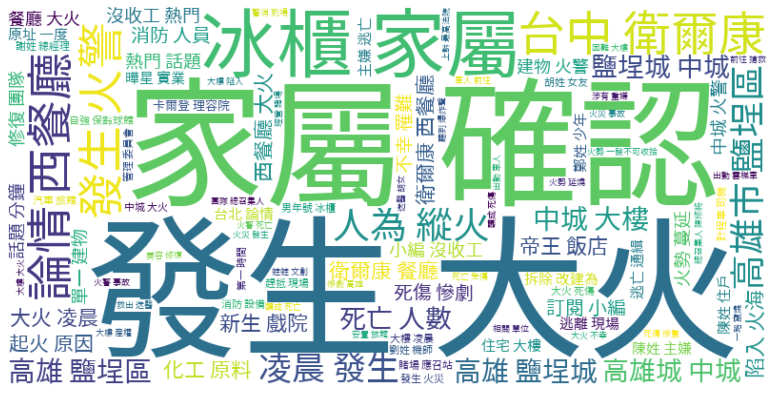

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_neg = stop_words
stop_words_neg.extend(('城中城','蔡姓保母','黃女'))
stop_words_neg = set(stop_words_neg)


# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(stopwords=stop_words_neg,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")\
            .generate(' '.join(negative_words['word']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

負面情緒出現「發生」、「大火」、「冰櫃」、「家屬」、「確認」等相關文字，可以看出發生了很嚴重的大事。

### 結論


藉由本次2021-10-01 ~ 2021-12-03　期間，ETtoday新聞網站內的「政治」、「社會」之新聞文章分析，發現以下幾點：

1.近期各大版報導的熱門人物、組織有哪些，新聞的主要討論話題(主題)

*   政治版多為「民進黨」、「國民黨」、「蔡英文」、「柯文哲」、「蘇貞昌」等政黨與政治人物，還有台美關係(萊豬、國安)等議題
*   社會版多為「林男」、「陳姓」、「林姓」、「張姓」等姓氏代稱居多，另外還有「台北地檢署」、「刑事局」、「最高法院」等字詞
*   兩個版共同出現了「高嘉瑜」(民進黨立委)、「林秉樞」關鍵字，為近期家暴案件的議題

2.近期各大版的新聞情緒分布的趨勢，正面和負面的新聞主要的討論焦點

*   政治版與社會的的情緒都偏負面，平均皆在0.2以下，而政治版除了國慶節那一陣，其他時間情緒普遍偏低，但社會版會起起伏伏，比較沒有特別一陣時間偏低或偏高。
*   政治版正面議題為國慶節，最負面的議題為台北市的重陽敬老金取消和重啟
* 社會版正面情緒中會出現「警方」、「調查」、「易科」、「罰金」等詞彙，表示當事件水落石出時，情緒較為正向；負面情緒則是在有嚴重的社會案件發生時會大量湧現。



# 第二部分：N-gram 與 TF-IDF

## 分析目標
分析主題：2021-10-01 ~ 2021-12-03　期間，ETtoday新聞網站內「財經版」新聞。
### 藉由本次的分析，希望可以回答以下問題：

1. 在財經版中tf-idf最大值的單字是那些？
  * 透過台灣新經濟日報TEJ+資料庫下載上市公司基本資料，透過結巴斷詞找出可形容台灣產業的單字，與公司名稱。
  * 引入自建的財經字典，對財經版文章斷詞、停字
  * 斷詞後的結果透過groupby計算tf與idf進而計算出tf-df值，並由大至小排列出來。
2. 找出：談及某些個股時，也經常一同提起的關鍵字
  * 透過自建財經辭典進行斷詞，並組建2-gram字典。
  * 計算最常同時出現的5個關鍵字，形成小型資料庫。

## 1. 資料前處理

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import math
!pip install ckiptagger[tf,gdown] wordcloud 
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

#cloab 字體設定
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

#新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

#將 font-family 設為 Taipei Sans TC Beta
#設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2021-12-07 07:19:22--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 64.233.191.102, 64.233.191.100, 64.233.191.139, ...
Connecting to drive.google.com (drive.google.com)|64.233.191.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ofrk74fe1papfjq8prmi8btdo45e4lij/1638861525000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-07 07:19:24--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ofrk74fe1papfjq8prmi8btdo45e4lij/1638861525000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.197.132, 2607:f8b0:4001:c1b::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|173.1

In [5]:
# 匯入資料
MetaData = pd.read_csv('./raw_data/MetaData_finance.csv', encoding='UTF-8')

# 清洗資料
MetaData = MetaData.dropna(how = 'any')
mask = MetaData['content'].str.len() <10
MetaData = MetaData[~mask]

# 留下中文及英文文字 因為許多科技、電子產業的產品都以英文命名
MetaData['content'] = MetaData.content.apply(lambda x: re.sub('[^\u4e00-\u9fa5a-zA-Z]+', '',x))
MetaData['content'] = MetaData.content.apply(lambda x: re.sub('記者.*報導', '',x))
MetaData = MetaData.iloc[:,1:]

In [6]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 設定特殊金融辭庫，包含國際金融機構名字、術語、台灣所有上市櫃公司、台灣產業、產業專有名詞
jieba.load_userdict('./dict/finance_dict.txt')

# 新增stop words；外加的extend list是由較後面的idf值較低的50個單字
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
stopWords.extend(['以元','作收','取自','圖庫','示意圖','億元','圖翻','攝自','外還','今日', '指出', '提供', '公司', '持續', '未來', '疫情', '相關',
       '超過', '影響', '透過', '資料', '產業', '企業', '包括',
       '推出', '服務', '國際', '科技', '時間', '產品', '增加', '預計', '明年',
       '技術', '合作', '國內', '公布', '經濟', '表現', '去年', '機會', '提升', '政府', '民眾',
       '客戶', '集團', '萬元', '獲利', '期間', '帶動', '活動', '近期', '希望',
       '日前', '銀行', '中國', '平台', '上漲', '設計', '業務', '系統', '最新', '整體', '國家',
       '包含', '方式', '推動', '數位', '業者', '預期', '選擇', '目標',
       '正式', '環境', '價格', '協助', '顯示', '規劃', '工作',
       '計畫', '消費', '趨勢', '開發', '政策', '台股', '預估', '交易', '員工', '供應鏈', '資訊',
       '舉辦', '中心', '旗下', '研發', '投資人', '股價', '指數', '特別', '數據', '上市',
       '經營', '擁有', '線上', '商品', '建議', '打造', '狀況', '消費者', '生活', '進一步', '減少',
       '智慧', '平均', '代表', '關注', '功能', '調整', '大廠', '投入', '參與', '因應'])

Building prefix dict from /content/drive/Shareddrives/社媒讀書會/第二次讀書會/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.ue54d73f9bb4e453980e86b708cbfdda8.cache
Loading model cost 2.255 seconds.
Prefix dict has been built successfully.


In [7]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list
# 設定 ngram 斷詞 function
def ngram_getToken(row,n):
  seg_list = jieba.lcut(row)
  seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
  seg_list = ngrams(seg_list, n)
  seg_list = [" ".join(w) for w in list(seg_list)]
  return seg_list

In [8]:
# 清除短資料或空資料
data = MetaData.copy()
mask = data['content'].str.len() < 10
data = data[~mask]
data = data.reset_index(drop = True)

# getToken by n grams
data['word'] = data.content.apply(getToken)

# 將word欄位展開
data = data.explode('word')

## 2. 計算tf-idf

In [9]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(['url','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [10]:
# 計算每篇文章的總字數
total_words = data.groupby('url',as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)

# 計算Term Frequency (TF) 
fin_words = word_count.merge(total_words,on = 'url',how = 'left')
fin_words['tf'] = fin_words['count']/fin_words['total']

# 計算IDF and tf-idf
idf_df = fin_words.groupby(['word'],as_index=False).size()
fin_words = fin_words.merge(idf_df,on = 'word',how = 'left')
fin_words['idf'] = np.log(len(set(fin_words['url']))/fin_words['size'])
fin_words['tf-idf'] = fin_words['tf']*fin_words['idf']
fin_words.head()

,url,word,count,total,tf,size,idf,tf-idf
0,https://www.ettoday.net/news/20211009/2097130.htm,Pay,15,146,0.102740,21,4.701778,0.483059
1,https://www.ettoday.net/news/20211009/2097130.htm,SOGO,1,146,0.006849,19,4.801862,0.032889
2,https://www.ettoday.net/news/20211009/2097130.htm,三越,1,146,0.006849,16,4.973712,0.034067
3,https://www.ettoday.net/news/20211009/2097130.htm,不收,1,146,0.006849,2,7.053153,0.048309
4,https://www.ettoday.net/news/20211009/2097130.htm,五倍券,8,146,0.054795,157,2.690055,0.147400


In [11]:
# 選出每篇文章，tf-idf值最大的5個詞
group = fin_words.groupby("url").apply(lambda x : x.nlargest(5, "tf-idf"))
group.loc[:,["word","tf-idf"]][:5]

word    tf-idf
url                                                                
https://www.ettoday.net/news/20211009/2097130.htm 0   Pay  0.483059
                                                  55   綁定  0.275147
                                                  4   五倍券  0.147400
                                                  17   台灣  0.106917
                                                  56   網站  0.091832

In [12]:
# 從每篇文章挑選出tf-idf最大的十個詞
(fin_words.groupby("url").apply(lambda x : x.nlargest(10, "tf-idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) 
#排序看最常成為文章tf-idf前10大 - 排行榜

,word,size
8577,美元,84
9147,蘋果,68
3209,台積電,58
10773,電動車,54
10528,開出,46
5892,新台幣,45
10401,金管會,42
11162,鴻海,39
1603,五倍券,37
8902,航空,36


## 3. 透過結巴斷詞與N-gram


### Bigram

In [13]:
# 資料清洗
fin_bigram = MetaData.copy()
mask = fin_bigram['content'].str.len() < 10
fin_bigram = fin_bigram[~mask].reset_index(drop = True)

# bi gram斷詞
fin_bigram["word"] = fin_bigram.content.apply(lambda x : ngram_getToken(x,2))
fin_bigram = fin_bigram.explode('word')

# 計算每個組合出現的次數
fin_bigram_count = fin_bigram.groupby(["word"],as_index=False).size()

# 清除包含英文或數字的bigram組合
wb_filter = list(fin_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
fin_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
75940,地方 創生,232
121249,振興 五倍券,155
132125,新光 三越,123
138035,晶圓 代工,110
265944,點或 收點,99
224499,貨櫃 三雄,96
192085,經濟部長 王美花,96
58883,去年同期 成長,95
202934,臨床 試驗,85
154449,永續 發展,81


### Trigram

In [14]:
'''
# 資料清洗
tri_bigram = MetaData.copy()
mask = tri_bigram['content'].str.len() < 10
tri_bigram = tri_bigram[~mask].reset_index(drop = True)

# bi gram斷詞
tri_bigram["word"] = tri_bigram.content.apply(lambda x : ngram_getToken(x,3))
tri_bigram = tri_bigram.explode('word')

# 計算每個組合出現的次數
tri_bigram_count = tri_bigram.groupby(["word"],as_index=False).size()

# 清除包含英文或數字的Trigram組合
wb_filter = list(tri_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
tri_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)
'''

'\n# 資料清洗\ntri_bigram = MetaData.copy()\nmask = tri_bigram[\'content\'].str.len() < 10\ntri_bigram = tri_bigram[~mask].reset_index(drop = True)\n\n# bi gram斷詞\ntri_bigram["word"] = tri_bigram.content.apply(lambda x : ngram_getToken(x,3))\ntri_bigram = tri_bigram.explode(\'word\')\n\n# 計算每個組合出現的次數\ntri_bigram_count = tri_bigram.groupby(["word"],as_index=False).size()\n\n# 清除包含英文或數字的Trigram組合\nwb_filter = list(tri_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))\ntri_bigram_count[wb_filter].sort_values(by=[\'size\'], ascending=False).head(10)\n'

## 4. 建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

In [15]:
fin_predict = MetaData.copy()
fin_predict_tokens = fin_predict.content.apply(getToken).tolist()

plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號

In [16]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [17]:
fin_predict = ngram(fin_predict_tokens, N=2)

### 輸入文字，輸出前十大常出現的文字

In [18]:
# 輸入單字，顯示最常一起出現的10個單字 
text = input("輸入字元") # 可嘗試輸入右方字詞：FED 通貨膨脹 鮑威爾 Taper IC Omicron 
next_words = list(fin_predict[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:10]:
  print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

輸入字元鮑威爾
next word: JeromePowell, probability: 0.222
next word: 續任, probability: 0.222
next word: 結束, probability: 0.111
next word: Fed, probability: 0.111
next word: 主席, probability: 0.111
next word: 示警, probability: 0.111
next word: 美國, probability: 0.111


### 5. Bigram視覺化

In [19]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [20]:
fin_bigram = MetaData.copy()
mask = fin_bigram['content'].str.len() < 10
fin_bigram = fin_bigram[~mask]
fin_bigram = fin_bigram.reset_index(drop = True)

fin_bigram["word"] = fin_bigram.content.apply(bigram_getToken_dict)
fin_bigram = fin_bigram.explode('word')
# 最常同時出現的雙字詞組合
bigramfdist.most_common(5)

[(('地方', '創生'), 232),
 (('振興', '五倍券'), 155),
 (('ETtoday', '新聞'), 134),
 (('新光', '三越'), 123),
 (('晶圓', '代工'), 110)]

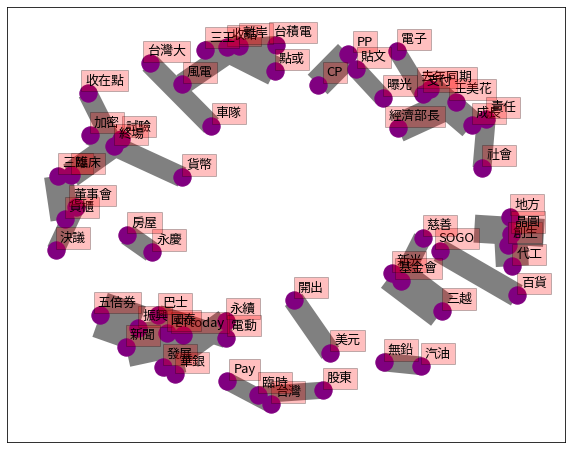

In [21]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.3 for w in  G.edges(data=True)]

####################

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
# 繪製共現圖    
plt.show()

# 第三部分
## 大綱
1. 套件說明
2. 文字前處理
    + 2.1 讀取資料
    + 2.2 斷句
    + 2.3 斷詞（刪掉次數太少的、標點符號、停用字）
    + 2.4 資料集基本檢視
3. 將資料分為測試集和訓練集
    + 3.1 根據7:3的比例切分資料集
4. 定義建模與畫圖的函數
5. 比較不同模型和資料組合的訓練結果
    + 5.1 Logistic Regression
    + 5.2 SVC
    + 5.3 Decision Tree
    + 5.4 預測結果探索

## 分析目標
分析主題：將 ETtoday 蒐集之新聞文章，利用其新聞類別，分為「財經」、「社會」、「體育」三大標籤，再用線性模型進行文件的分類，希望分析可以獲得以下資訊：
+ 資料內容：
    + 資料來源：ETtoday 財經、社會、體育 版 (各2500筆，共7500筆)
    + 資料集： `raw_data/MetaData_Finance.csv`、`raw_data/MetaData_Society.csv`、、`raw_data/MetaData_Sport.csv`
    + 資料時間：2021/10~2021/12
    + 分類: 財經、社會、體育 共三種標籤

1. 三個類別的文章字詞分部有甚麼不同，代表字詞有哪些？
    +  討論章節：2.4 資料集基本檢視
        + 斷詞後檢視詞頻
    + 討論章節：5.4.1 各字詞特徵的estimate係數
        + 利用建模後的estimate係數挑選各文集代表字
2. 此資料集用什麼樣的模型預測，準確率會較高？
    + 討論章節：5.4.3 比較不同模型的ROC
        + 以不同模型的ROC比較準確率

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具
- time: 獲得目前的時間或作時間格式轉換的工具

In [ ]:
import pandas as pd
import re
import time
import string
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import jieba

import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
# cloab 字體設定
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2021-12-06 12:07:45--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.1.100, 142.250.1.101, 142.250.1.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.1.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/95c5a6hvqbk067ao3q9s9rkhaej49bgf/1638792450000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-06 12:07:50--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/95c5a6hvqbk067ao3q9s9rkhaej49bgf/1638792450000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.124.132, 2607:f8b0:4001:c14::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|74.125.124

## 2. 文字前處理
在這邊我們先把句子斷開，一個句子代表一個文件(document)，因為每個 document 需要標上不同的類別標籤，我們先將每個句子斷詞，為了後面建立 DTM(document-term-matrix) 我們先清理停用字和詞頻太少的句子，並做基本的文件探索。

### 2.1 讀取資料

In [ ]:
#匯入資料
news_fi = pd.read_csv("raw_data/MetaData_Finance.csv") #讀取財經類新聞文章
news_fi = news_fi.iloc[:][:2500] #取出前2500筆資料

news_so = pd.read_csv("raw_data/MetaData_Society.csv") #讀取社會類新聞文章
news_so = news_so.iloc[:][:2500] 

news_sp = pd.read_csv("raw_data/MetaData_Sport.csv") #讀取體育類新聞文章
news_sp = news_sp.iloc[:][:2500] 

In [ ]:
news_fi.head(3)

,artDate,title,category,url,content
0,2021/12/2 23:30,台積電投資「翻轉高雄失落30年」 謝金河：將拉近與台北房價差距,財經,https://www.ettoday.net/news/20211202/2137478.htm,▲財信傳媒董事長謝金河發文指出，台積電投資高雄有望拉近北高房價差距。（資料照／記者湯興漢攝）...
1,2021/12/2 23:16,普生腫瘤細胞檢測獲大型醫療中心採用 總座林孟德：明年營運樂觀,財經,https://www.ettoday.net/news/20211202/2137453.htm,▲普生董事長林宗慶（左）、普生總經理林孟德（右）。（圖／記者吳康瑋攝）記者吳康瑋／綜合報導精...
2,2021/12/2 23:09,席捲亞洲當代 領頭羊來勢洶洶,財經,https://www.ettoday.net/news/20211202/2137364.htm,文．蔡武穆國內百位新銳藝術家共同合作，以台灣人的民族性為發想，創作出代表台灣意象的藝術公仔，...


In [ ]:
#合併所有類別的文章
news_df = pd.concat([news_fi,news_so,news_sp], ignore_index=True)

In [ ]:
print(f"共有 {news_df.shape[0]} 篇新聞文章") #(row,column)
print(f"共有 {news_df.category.unique()} 三大類別") #(row,column)

共有 7498 篇新聞文章
共有 ['財經' '社會' '體育'] 三大類別


### 2.2 斷句
+ 資料清理步驟:
  + 去除 全形括號()與括號內的字詞: 內容大多是圖片描述等不重要的資訊
  + 去除 "記者XXX/OO報導" 這句話: 去掉報導新聞的記者名字
  + 去除 特殊符號
+ 利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [ ]:
def cut_sent(para):
    para = re.sub(r'\（[^（）]*\）','', para) #去除全形括號()+括號內的字詞: 內容大多是圖片描述等不重要的資訊
    para = re.sub(r'記者.+／.*報導','', para) #去除 記者XXX/OO報導 這句話: 去掉報導新聞的記者名字
    para = re.sub(r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─▲⋯]+','', para) #去除特殊符號
    para = re.sub('([。!！？\?；;])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

文章的標題`title`和內文`content`都會納入分析的內容，成為新的`contents`欄位。

In [ ]:
# 篩選需要的欄位
news_df['contents'] = news_df['title'] + news_df['content']
news_df = news_df.dropna() #去掉空白欄位
data = news_df[['contents','category','url']] #文章內容、文章類別、文章連結

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['contents']), axis=1) #把句子切開
data = data[['sentence','category','url']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,category,url,document
0,台積電投資翻轉高雄失落30年 謝金河將拉近與台北房價差距財信傳媒董事長謝金河發文指出，台積電...,財經,https://www.ettoday.net/news/20211202/2137478.htm,0
0,財訊傳媒董事長謝金河今天在臉書發文指出，台積電赴高雄設廠，可為高雄帶來新的產業聚落，高雄人經...,財經,https://www.ettoday.net/news/20211202/2137478.htm,1
0,以下謝金河臉書全文車行高雄街頭，抬頭看見榮耀高雄四個大字，署名煙斗雄的人跪求台積電來高雄投資...,財經,https://www.ettoday.net/news/20211202/2137478.htm,2


In [ ]:
# 看看有幾個句子
print(f"total sentences: {data.shape[0]}")

total sentences: 70960


### 2.3 斷詞
+ 進行斷詞
    + 去除標點符號
    + 去除stopwords
    + 篩選出現太少次的字

In [ ]:
def load_stop_words(path):
    with open(path) as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典  
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)
    # 參數形式手動加入停用字
    user_stop = ["表示","指出","真的","一起","今年","今日","認為","目前","希望","想到","當時"]
    for i in user_stop:
       stopWords.append(i)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [ ]:
# 這裡會跑比較久
stop_path = 'dict/stopwords.txt'
user_path = "dict/user_dict.txt"

# 把句子切開，待會丟DTM
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 

In [ ]:
data.head(3)

,sentence,category,url,document,clean_txt
0,台積電投資翻轉高雄失落30年 謝金河將拉近與台北房價差距財信傳媒董事長謝金河發文指出，台積電...,財經,https://www.ettoday.net/news/20211202/2137478.htm,0,台積電 投資 翻轉高雄 失落 謝金河 拉近 台北 房價 差距 財信 傳媒 董事長 謝金河 發...
0,財訊傳媒董事長謝金河今天在臉書發文指出，台積電赴高雄設廠，可為高雄帶來新的產業聚落，高雄人經...,財經,https://www.ettoday.net/news/20211202/2137478.htm,1,財訊傳媒 董事長 謝金河 臉書 發文 台積電 高雄 設廠 可為 高雄 帶來 產業 聚落 高雄...
0,以下謝金河臉書全文車行高雄街頭，抬頭看見榮耀高雄四個大字，署名煙斗雄的人跪求台積電來高雄投資...,財經,https://www.ettoday.net/news/20211202/2137478.htm,2,謝金河 臉書 全文 車行 高雄 街頭 抬頭 榮耀 高雄 四個 大字 署名 煙斗雄 跪求 台積...


In [ ]:
# 把字詞斷開
token_df = data[['document','clean_txt','category']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','category','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,document,category,word
0,0,財經,台積電
1,0,財經,投資
2,0,財經,翻轉高雄
3,0,財經,失落
4,0,財經,謝金河


In [ ]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 97761


### 2.4 資料集基本檢視
檢視資料內容

In [ ]:
print(f"total posts: {len(data.url.unique())}")
print(f"total sentences: {len(data.document.unique())}")

total posts: 7310
total sentences: 70960


In [ ]:
# 算各類別資料框的字頻
word_count = token_df.groupby(['category','word'], as_index=False).size().sort_values(by=['size'], ascending=False)
word_count.head(3)

,category,word,size
41028,社會,警方,4094
58656,財經,台灣,3127
103306,體育,安打,2582


In [ ]:
# 選出各類別文章最高的20個字
top_n = 20
word_fi = word_count[word_count["category"]=="財經"].head(top_n).sort_values(by=['size']) # 財經類
word_so = word_count[word_count["category"]=="社會"].head(top_n).sort_values(by=['size']) # 社會類
word_sp = word_count[word_count["category"]=="體育"].head(top_n).sort_values(by=['size']) # 體育類

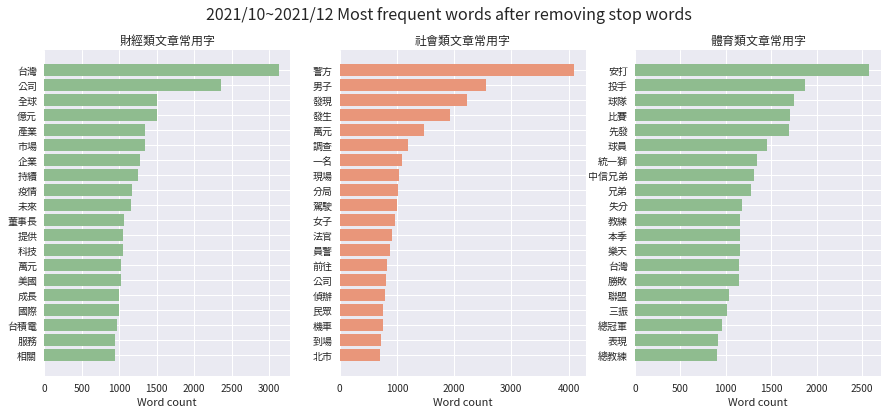

In [ ]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(15,6))   
plt.style.use('seaborn') 
plt.rcParams['font.family'] = 'Taipei Sans TC Beta'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文

plt.subplot(131)
plt.title('財經類文章常用字')
plt.xlabel('Word count')
plt.barh(word_fi['word'],word_fi['size'],color="darkseagreen")

plt.subplot(132)
plt.title('社會類文章常用字')
plt.xlabel('Word count')
plt.barh(word_so['word'],word_so['size'],color="darksalmon")

plt.subplot(133)
plt.title('體育類文章常用字')
plt.xlabel('Word count')
plt.barh(word_sp['word'],word_sp['size'],color="darkseagreen")

# 最上面的標題
plt.suptitle('2021/10~2021/12 Most frequent words after removing stop words', fontsize=16)
plt.show()

可以發現:
+ 財經類文章 - 經常出現「董事」、「美元」、「疫情」、「台積電」等字詞，主要在討論各大公司的董事對於全球市場的觀點、美股與台股間的關係、疫情對金融市場的影響以及護國神山台積電的動態等。
+ 社會類文章 - 經常出現「警方」、「調查」、「現場」、「罪嫌」等字詞，多在描述社會案件的情形，例如:警方調查結果、法官判決、罪嫌身分等。另外「凌晨」這個詞也常出現，可能是因為社會案件經常發生在凌晨時分。
+ 體育類文章 - 經常出現「安打」、「投手」、「比賽」、「味全」、「統一獅」、「中信兄弟」等字詞，主要在討論本季的中華職棒比賽

## 3. 將資料切成訓練集與測試集
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每篇新聞文章所屬的類別）。

In [ ]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data, stratify=data["category"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["category"].values
y_test = dtf_test["category"].values

In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data['category'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['category'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['category'].value_counts(normalize=True) * 100}")

raw data percentage :
財經    36.200676
社會    34.315107
體育    29.484216
Name: category, dtype: float64

train percentage :
財經    36.201482
社會    34.315107
體育    29.483411
Name: category, dtype: float64

test percentage :
財經    36.198797
社會    34.315107
體育    29.486095
Name: category, dtype: float64


## 4. 定義建模與畫圖的函數
因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數

In [ ]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(train_data)    # <---- *Modified* ----
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [ ]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

ROC 適用二元分類，故將每個類別(財經、社會、體育版)的預測都視作為一個二元分類，以下比較上面各模型的分類效果

### Step 1 定義 vectorizer

In [ ]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

### Step 2 定義 classifier

In [ ]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

### Step 3 定義測試和訓練資料集

In [ ]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [ ]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

## 5. 比較不同模型和資料組合的訓練結果

### 5.1 Model Building : logistic regression
+ TF-IDF + logistic regression > Accuracy: 0.94, Auc: 0.99
+ CV + logistic regression > Accuracy: 0.94, Auc: 0.99


model type: TF-IDF + logistic regression
time costing: 11.960227251052856
Accuracy: 0.95
Auc: 0.99
Detail:
              precision    recall  f1-score   support

          社會       0.93      0.95      0.94      7305
          財經       0.94      0.95      0.95      7706
          體育       0.98      0.95      0.96      6277

    accuracy                           0.95     21288
   macro avg       0.95      0.95      0.95     21288
weighted avg       0.95      0.95      0.95     21288



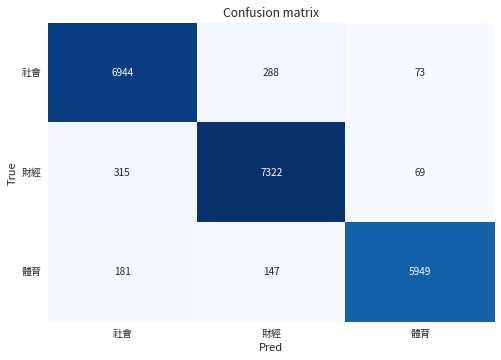

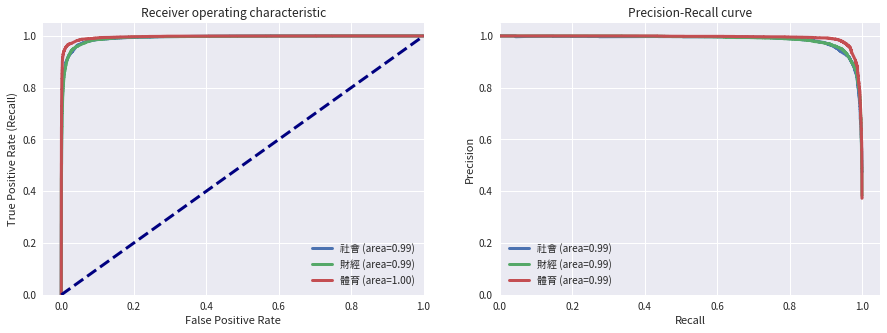

In [ ]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_tfidf, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: CV + logistic regression
time costing: 12.4334135055542
Accuracy: 0.94
Auc: 0.99
Detail:
              precision    recall  f1-score   support

          社會       0.92      0.95      0.94      7305
          財經       0.94      0.94      0.94      7706
          體育       0.97      0.94      0.96      6277

    accuracy                           0.94     21288
   macro avg       0.95      0.94      0.95     21288
weighted avg       0.95      0.94      0.95     21288



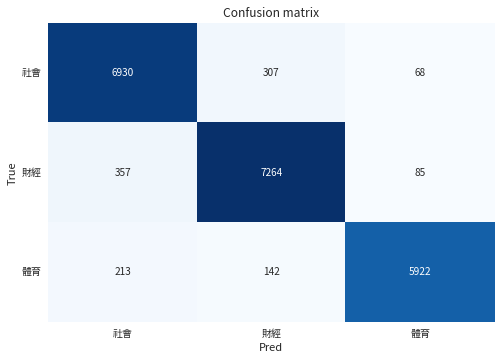

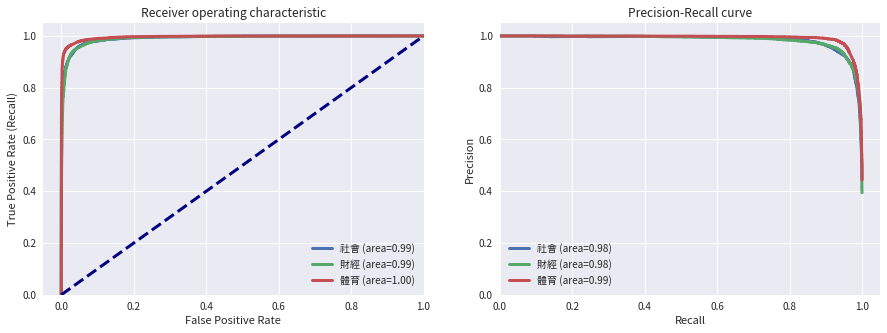

In [ ]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.2 Model Building : SVC
+ TF-IDF + SVC > Accuracy: 0.95, Auc: 0.99
+ CV+SVC > Accuracy: 0.93，Auc: 0.99


model type: TF-IDF + SVC
time costing: 3358.7633538246155
Accuracy: 0.95
Auc: 0.99
Detail:
              precision    recall  f1-score   support

          社會       0.94      0.96      0.95      7305
          財經       0.95      0.96      0.95      7706
          體育       0.98      0.95      0.97      6277

    accuracy                           0.95     21288
   macro avg       0.96      0.95      0.95     21288
weighted avg       0.95      0.95      0.95     21288



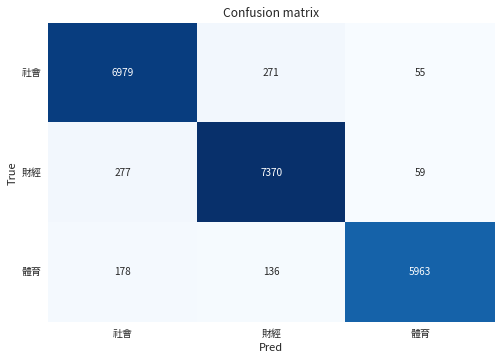

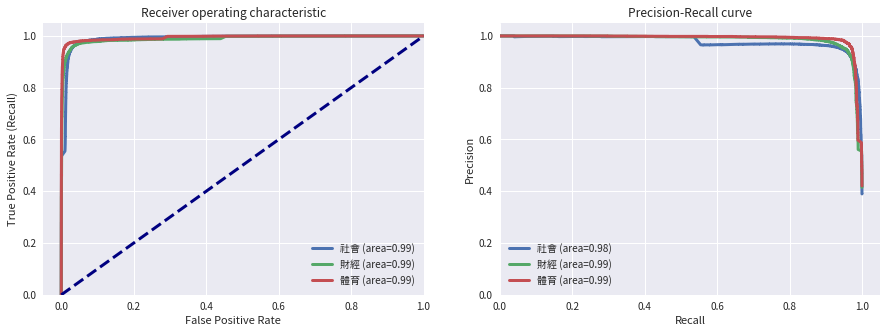

In [ ]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

In [ ]:
"""
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

"""

### 5.3 Model Building : RandomForest
+ TF-IDF + RandomForest > Accuracy: 0.9, Auc: 0.98

model type: TF-IDF + RandomForest
time costing: 86.67473363876343
Accuracy: 0.91
Auc: 0.99
Detail:
              precision    recall  f1-score   support

          社會       0.89      0.92      0.90      7305
          財經       0.90      0.91      0.91      7706
          體育       0.96      0.91      0.93      6277

    accuracy                           0.91     21288
   macro avg       0.92      0.91      0.91     21288
weighted avg       0.91      0.91      0.91     21288



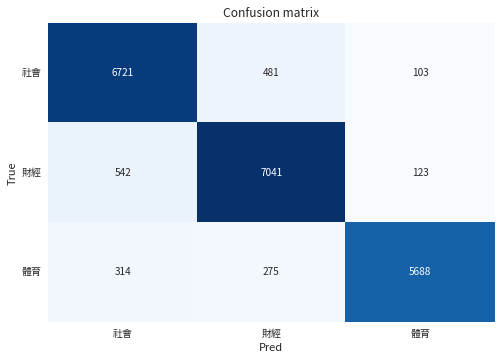

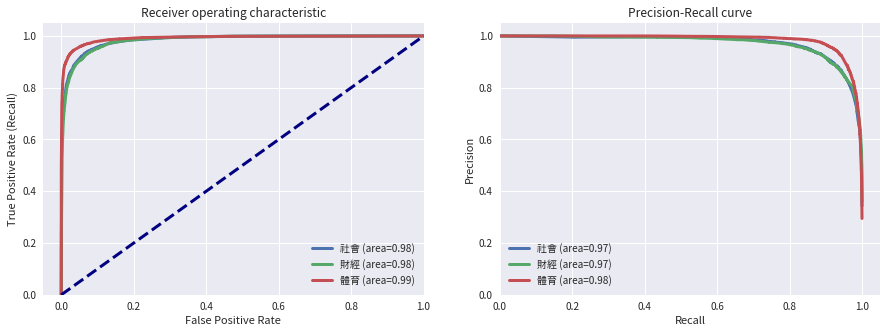

In [ ]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.4 預測結果探索
+ 5.4.1 各字詞特徵的estimate係數
+ 5.4.2 查看分類錯誤的句子
+ 5.4.3 比較不同模型的ROC

查看模型預測結果

In [ ]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
2,TF-IDF + SVC,0.954153,0.991033
0,TF-IDF + logistic regression,0.949596,0.993622
1,CV + logistic regression,0.944946,0.992451
3,TF-IDF + RandomForest,0.913660,0.985665


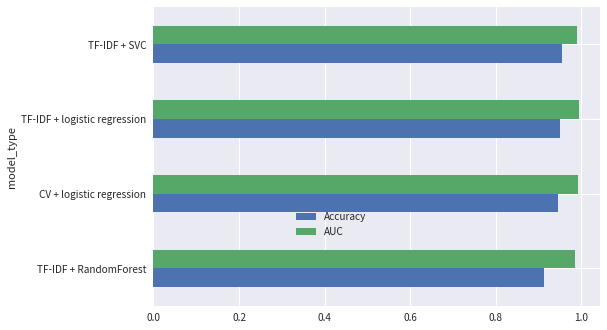

In [ ]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

可以看到效果最好的組合是 TF-IDF 加上 SVC 的模型

### 5.4.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 5.1 的 logistic regression + cv tokenizer 為例

In [ ]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [ ]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names_out()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

,社會,財經,體育
一一,-0.021272,-0.000115,-0.009735
一七,0.256042,-0.110626,-0.553568
一三,-0.470155,-0.196707,-0.129860
一中,-0.601732,0.270033,0.168477
一事,0.224709,0.077528,0.090333


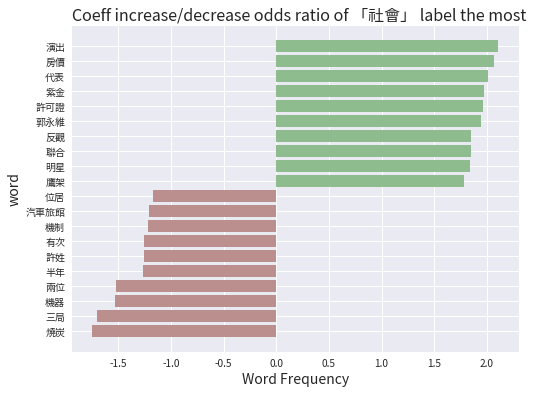

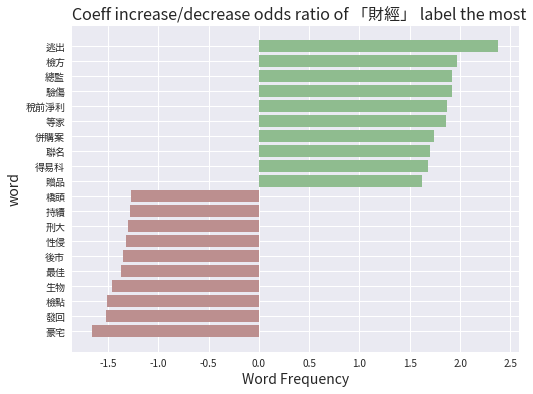

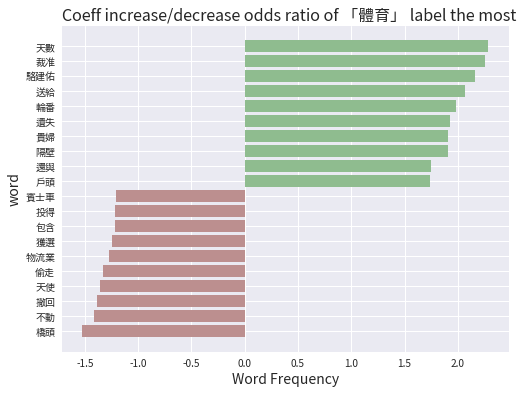

In [ ]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

+ 「美東線」、「鴻海」 等字是影響判斷為財經類的重要字
+ 「行政法院」、「案例」、「酒測值」 等字是影響判斷為社會類的重要字
+ 「懊悔」、「博覽會」 等字是影響判斷為體育類的重要字

### 5.4.2 查看分類錯誤的句子

In [ ]:
# 把預測的值加回去
dtf_test['predict'] = pred
fi_wrong = dtf_test.loc[(dtf_test['category'] != dtf_test['predict']) & (dtf_test['category'] == '財經')] # 財經類句子分錯
so_wrong = dtf_test.loc[(dtf_test['category'] != dtf_test['predict']) & (dtf_test['category'] == '社會')] # 社會類句子分錯
sp_wrong = dtf_test.loc[(dtf_test['category'] != dtf_test['predict']) & (dtf_test['category'] == '體育')] # 體育類句子分錯

print(f"finance label predicted wrong: {fi_wrong.shape[0]}")
print(f"society label predicted wrong: {so_wrong.shape[0]}")
print(f"sport label predicted wrong: {sp_wrong.shape[0]}")

finance label predicted wrong: 665
society label predicted wrong: 584
sport label predicted wrong: 589


看一下都是什麼樣的句子分錯

In [ ]:
# 財經類句子分錯
fi_wrong[['sentence','url','category','predict']].head(5)

,sentence,url,category,predict
1006,物價飆漲立委批紙老虎 公平會目前尚未發現聯合漲價立法院經濟委員會今審查公平會預算。,https://www.ettoday.net/news/20211110/2120569.htm,財經,社會
1581,稅額在新臺幣3萬元以下者，可於11月3日前使用工商憑證或統一編號加車號，透過便利商店多媒體資...,https://www.ettoday.net/news/20211029/2111895.htm,財經,社會
489,"女大生也貼出庫存單，她累計投入268,385元，目前市值為351,565元，總共賺進了83,...",https://www.ettoday.net/news/20211121/2128535.htm,財經,社會
89,還有1位幸運兒在高雄燕巢的萊爾富援巢店，花150元儲值iWIN點數卡，就中了1000萬元特別獎。,https://www.ettoday.net/news/20211202/2136667.htm,財經,社會
2486,測評網站DxOMark公布iPhone13iPhone13mini的相機測評結果，總分得到1...,https://www.ettoday.net/news/20211010/2098238.htm,財經,體育


In [ ]:
# 社會類句子分錯
so_wrong[['sentence','url','category','predict']].head(5)

,sentence,url,category,predict
4899,縱然賴惠員關於告訴人選舉資金之花費龐大所言屬實，惟依上述2位證人所證，其等均不知告訴人競選資...,https://www.ettoday.net/news/20211102/2115075.htm,社會,財經
2761,蕭昨日也接受電訪表示，承辦離岸風電調查報告水下文化資產調查儀器設備雲端火災預警系統規劃建置等...,https://www.ettoday.net/news/20211130/2134910.htm,社會,財經
4979,法官指妙天表示楊岐自稱許水德的機要秘書和總統府秘書長熟識，也和陳履安很熟，最主要是因為這樣的...,https://www.ettoday.net/news/20211101/2114358.htm,社會,財經
2669,圖文鏡週刊呂太太是名符其實的理科太太，她取得國立成功大學材料研究所碩士後，又去英國留學，攻讀...,https://www.ettoday.net/news/20211201/2135698.htm,社會,財經
4428,辣妹都回來了！,https://www.ettoday.net/news/20211109/2119697.htm,社會,體育


In [ ]:
# 體育類句子分錯
sp_wrong[['sentence','url','category','predict']].head(5)

,sentence,url,category,predict
6232,戴資穎紀念口罩共捐17萬5540元 助勵馨基金會關懷弱勢戴資穎紀念口罩。,https://www.ettoday.net/news/20211104/2116565.htm,體育,財經
6051,愛爾達將繼續扮演提升國內籃球收視人口任務，並強化籃球轉播市場深度。,https://www.ettoday.net/news/20211111/2121562.htm,體育,財經
6826,徐若熙為今年表現打80分，100局沒有完成，後面跟季初想的有一點落差，沒辦法把每一球控制好，...,https://www.ettoday.net/news/20211022/2107518.htm,體育,社會
5743,在討論的過程中，如果對方非常堅持己見，葉總表示，自己會接受意見，去嘗試看看，我不一定是對的，...,https://www.ettoday.net/news/20211116/2125107.htm,體育,財經
5233,孫穎莎一日4戰全勝！,https://www.ettoday.net/news/20211129/2134355.htm,體育,社會


## 結論
1. 各類別的字詞分佈有甚麼不同，代表字詞有哪些？
+ 初步用詞頻探索發現:
  + 「財經類」文章 出現的詞有「董事」、「美元」、「疫情」、「台積電」等詞彙
  + 「社會類」文章 出現的詞有「警方」、「調查」、「現場」、「罪嫌」等詞彙
  + 「體育類」文章 出現的詞有「安打」、「投手」、「比賽」、「味全」、「統一獅」、「中信兄弟」等詞彙
2. 此資料集用什麼樣的模型預測，準確率會較高？
    +  使用 TF-IDF + SVC 和 TF-IDF + logistic regression 模型的表現較好，可能是因為各類別的新聞文章會使用一些特定的字詞，讓TF-IDF 提取的特徵更加有效。